<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [3]:
download = False
if not os.path.isfile("./t10k-images-idx3-ubyte.gz"):
    download = True

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

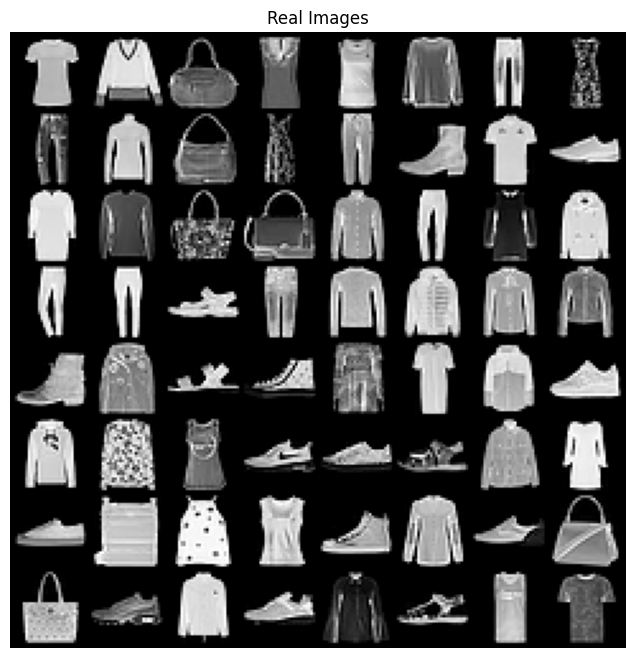

In [4]:
import matplotlib.pyplot as plt


real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

![image.png](attachment:./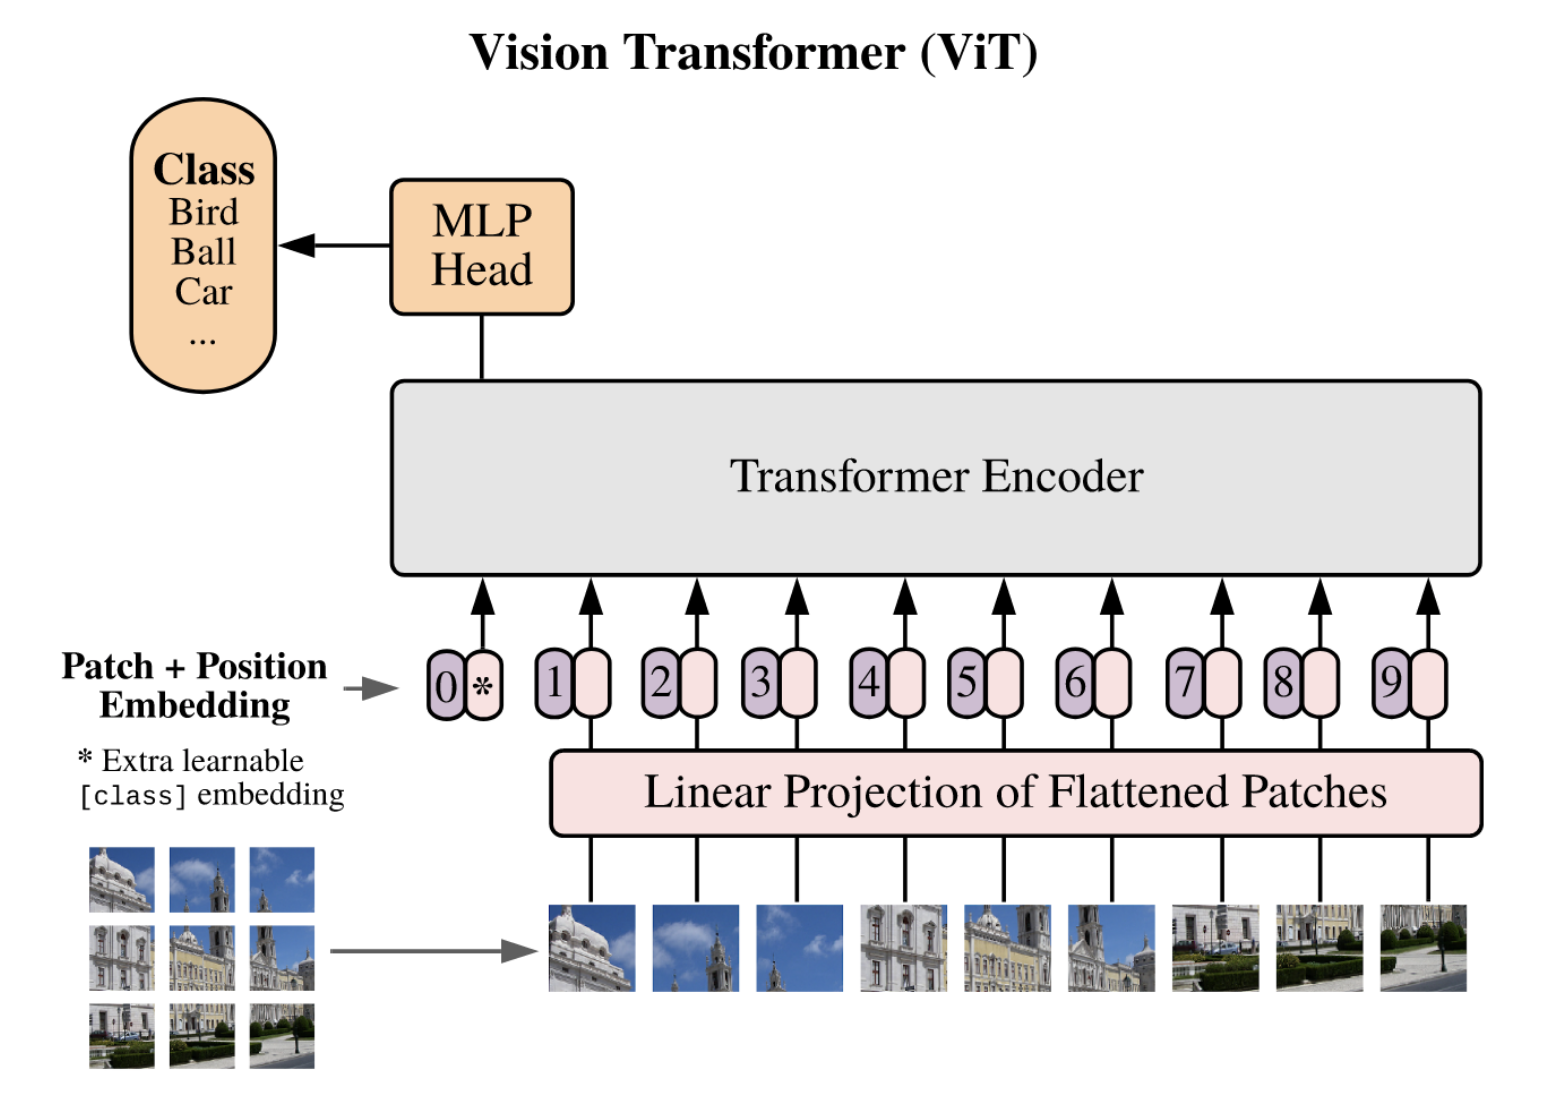)

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [5]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    """
      x.shape : (Batch, Channels, height, width)
    """
    x = self.projection(x)
    
    B, C, H, W = x.size() # Here C = embedding_dim

    # Reshape from B x C x H x W to B x N x C where N is H*W (the number of 'tokens').
    x = x.view(B, C, -1) # Flatten the H and W dimensions.
      
    # Shape is now B x C x N, we simply need to permute to get B x N x C 
    x = x.permute(0, 2, 1)

    # x.size() -> B, N, C
    return x

In [6]:
PatchEmbed(in_chan=2)(torch.randn(32, 2, 28, 28)).size()

torch.Size([32, 16, 128])

# Transformer encoder

![image.png](attachment:./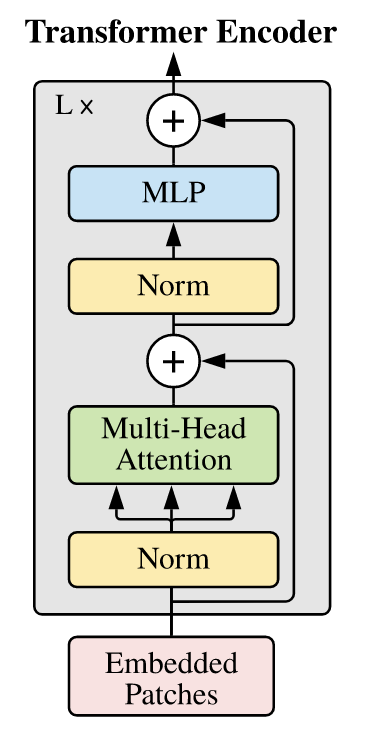)

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [7]:

class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.seq = nn.Sequential(nn.Linear(in_features, hid_features), nn.GELU(), nn.Linear(hid_features, in_features)) 

  def forward(self, x):
    return self.seq(x)


MLP(128, 512)(torch.randn(32, 16, 128)).size()

torch.Size([32, 16, 128])

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart? What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!

**Answer in the reports 😉**

## Q3: Self-attention

In [8]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim, final_linear=True):
    super().__init__()
    self.scale = embed_dim**0.5
    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    if final_linear:
      self.final_linear = nn.Linear(embed_dim, embed_dim)
    else:
      self.final_linear = lambda x: x

  def forward(self, x):
    """
    B : batch size
    N : nombre d'embedding = nombre de patch d'image 
    C : taille d'un embedding 
    """
    B, N, C = x.shape

    # Compute the Q, K, V
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)

    # Compute the final version using the attention V, and the final projection
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v
    return self.final_linear(x)

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

**Answer in the reports 😉**

In [9]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)
      
    print(q.size())

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.
    
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO

    return x

  def transpose_qkv(self, X):
      """Transposition for parallel computation of multiple attention heads."""
      # Shape of input X: (batch_size, no. of queries or key-value pairs, num_hiddens). 
      # Shape of output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens / num_heads)
      X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
      # Shape of output X: (batch_size, num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      X = X.permute(0, 2, 1, 3)
      # Shape of output: (batch_size * num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      return X.reshape(-1, X.shape[2], X.shape[3])
  
  
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])


torch.Size([32, 16, 6])

In [10]:
class MultiHeadsSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        # Validate that the embedding dimension is divisible by the number of heads
        if embed_dim % num_heads != 0:
            raise ValueError("Embedding dimension must be divisible by the number of heads.")

        self.num_heads = num_heads
        head_dim = embed_dim // num_heads  # Determine the dimension size of each head
        self.scale = head_dim ** -0.5  # Scale factor for the dot product

        # These are the linear layers used for the multi-head attention
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)

        # This is the final linear layer used after the self-attention
        self.projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # Batch size, number of tokens, and embedding dimension

        # First, we pass through the linear layers
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        # Reshape Q, K, V for the attention computation
        q = q.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        k = k.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        v = v.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)

        # Scaled dot-product attention calculation
        ###################### On divise ou multipli par la scale attention ?
        attention_scores = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale  # Shape: (B, num_heads, N, N)
        attention = F.softmax(attention_scores, dim=-1)
        out = torch.matmul(attention, v)  # Shape: (B, num_heads, N, head_dim)

        # Concatenating the multi-head attention results
        out = out.permute(0, 2, 1, 3).contiguous().view(B, N, C)  # Shape: (B, N, C)

        # Final linear layer
        out = self.projection(out)  # Shape: (B, N, C)

        return out

    
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).size()

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

**Equations**:

**Answer in the reports 😉**

In [11]:
# normalisation : use layer norm from pytorch, similar to batch normalisation but the mean & std is computed across the channel feature
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)

  def forward(self, x):
    out = self.norm(x)
    out = self.attention(out)
    x = out + x
    out = self.norm(x)
    out = self.mlp(out)
    return out + x

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

In [12]:

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
        super().__init__()

        # Multi-head self-attention mechanism
        self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward neural network (MLP)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, mlp_ratio * embed_dim),  # Linear layer
            nn.GELU(),  # Activation function
            nn.Linear(mlp_ratio * embed_dim, embed_dim),  # Linear layer
        )

    def forward(self, x):
        # Apply multi-head attention followed by layer normalization
        attention_output = self.attention(x)
        x = self.norm1(x + attention_output)  # Residual connection

        # Apply feed-forward neural network followed by layer normalization
        feed_forward_output = self.feed_forward(x)
        x = self.norm2(x + feed_forward_output)  # Residual connection

        return x

    
Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

![](https://www.researchgate.net/publication/348947034/figure/fig2/AS:986572736446471@1612228678819/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the.png)

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

1. Explain what is a Class token and why we use it? 
2. Explain what is the positional embedding (PE) and why it is important?

**Answer in the reports 😉**

### Sinusoidal PE

In [13]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10, num_heads=4, mlp_ratio=4):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.ones(1, embed_dim),requires_grad=False)
    self.pos_embed = nn.Parameter(self.get_positional_embeddings(num_patches+1, embed_dim), requires_grad=False)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(Block(embed_dim, num_heads=num_heads, mlp_ratio=num_heads))
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Sequential(
            nn.Linear(embed_dim, nb_classes),
            nn.Softmax(dim=-1)
        )

  @staticmethod
  def get_positional_embeddings(sequence_length, d):
    """
    given the number of tokens and the dimensionality of each of them, 
    outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.
    """
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result
  
  def forward(self, x):
    batch_size = x.size(0)
    x = self.patch_embed(x) ## image to patches => B, N, C

    ## concatenating class token of shape (1, embedding dim) for every example
    x = torch.cat((self.class_token.repeat(batch_size, 1, 1), x), dim=1)
    
    ## adding positional embedding
    x += self.pos_embed.repeat(batch_size, 1, 1)

    ## forward in the transformer
    x = self.blocks(x)[:, 0, :] # We take only the CLS token
    
    ## Normalize the output
    x = self.norm(x)

    output = self.head(x) ## classification output

    return output
  


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [14]:
@torch.no_grad()
def eval_model(model, loader, num_classes):
  model.eval()
  acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  loss = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)
    loss += F.cross_entropy(yhat, y)
    acc(yhat.argmax(dim=1), y)

  model.train()
  return loss.item(), acc.compute().item()

And run! Feel free to try other hyperparameters.

In [15]:
import torchmetrics
from tqdm import tqdm
def main(epochs = 10, embed_dim = 32, patch_size = 7, nb_blocks = 2, num_classes=10, num_heads=4, mlp_ratio=4, model=None, tqdm_batch=False):
  if not model:
    model = ViT(embed_dim, nb_blocks, patch_size, num_heads=num_heads, mlp_ratio=mlp_ratio).cuda()
  if tqdm_batch:
    train_loader_main = tqdm(train_loader)
  else:
    train_loader_main = train_loader
  opt = torch.optim.Adam(model.parameters())
  acc_train = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  acc_train_list = []
  acc_test_list = []
  loss_train_list = []
  loss_test_list = []

  for epoch in (pbar := tqdm(range(epochs))):
    train_loss = 0.
    for x, y in train_loader_main:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()
      acc_train(yhat.argmax(dim=1), y)
      train_loss += loss.item()
    loss_train_list.append(train_loss / len(train_loader))
    acc_train_list.append(acc_train.compute().item())
    acc_train.reset()
    
    # Test eval
    loss_test, acc_test = eval_model(model, test_loader, num_classes)
    acc_test_list.append(acc_test)
    loss_test_list.append(loss_test)
    pbar.set_description(f"acc_train {acc_train_list[-1]:.3f} | acc_test {acc_test:.3f}")
  return acc_train_list, acc_test_list, loss_train_list, loss_test_list
  #   print(f"--- Epoch {epoch} ---")
  #   print(f"Train loss: {train_loss / len(train_loader)}")
  # print(f"Test accuracy: {acc}")
# main()

# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [16]:
def plot_plot_optimizers(plot_optimizers, save_name=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()

    for opt, values in plot_optimizers.items():
        ax[0].plot(values[0], label=f"{opt}")
        ax[1].plot(values[1], label=f"{opt}")
        ax[2].plot(values[2], label=f"{opt}")
        ax[3].plot(values[3], label=f"{opt}")

    ax[0].set_title("Train accuracy / epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_ylim([0, 1])

    ax[1].set_title("Test accuracy / epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_ylim([0, 1])

    ax[2].set_title("Train loss / epoch")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Loss")

    ax[3].set_title("Test loss / epoch")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("Loss")

    plt.legend()
    plt.tight_layout()
    if save_name:
        plt.savefig(f"{save_name}.pdf", dpi=100, bbox_inches="tight")
    plt.show()

In [17]:
# plot_optimizers_embed_dim = {}
# for embed_dim in [16,32,64,128]:
#     stats = main(epochs=15, embed_dim=embed_dim)
#     plot_optimizers_embed_dim[embed_dim] = stats

In [18]:
# plot_plot_optimizers(plot_optimizers_embed_dim, 'embed_dim_influence')

In [19]:
# plot_optimizers_patch_size = {}
# for patch_size in [2,4,7,14, 28]:
#     stats = main(epochs=15, patch_size=patch_size)
#     plot_optimizers_patch_size[patch_size] = stats

In [20]:
# plot_plot_optimizers(plot_optimizers_patch_size, 'patch_size_influence')

In [21]:
# plot_optimizers_nb_blocks = {}
# for nb_blocks in [2,4,6,8]:
#     stats = main(epochs=15, nb_blocks=nb_blocks)
#     plot_optimizers_nb_blocks[nb_blocks] = stats

In [22]:
# plot_plot_optimizers(plot_optimizers_nb_blocks, 'nb_block_influence')

In [23]:
# plot_optimizers_num_heads = {}
# for num_heads in [2,4,8,16]:
#     stats = main(epochs=15, num_heads=num_heads)
#     plot_optimizers_num_heads[num_heads] = stats

In [24]:
# plot_plot_optimizers(plot_optimizers_num_heads, 'num_heads_influence')

In [25]:
# plot_optimizers_mlp_ratio = {}
# for mlp_ratio in [2,4,6,8]:
#     stats = main(epochs=15, mlp_ratio=mlp_ratio)
#     plot_optimizers_mlp_ratio[mlp_ratio] = stats

In [26]:
# plot_plot_optimizers(plot_optimizers_mlp_ratio, 'mlp_ratio_influence')

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [27]:
%pip install timm > /dev/null

Note: you may need to restart the kernel to use updated packages.


a) Load the model using the timm library without pretrained weights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [28]:
import timm
# [k for k in timm.list_models() if 'vit_base' in k]

In [29]:
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
try:
    model(torch.randn(1, 1, 28, 28))
except AssertionError as err:
    print(err)

Input height (28) doesn't match model (224).


The model vit_base_patch16_224 is trained on 224x224 images from the ImageNet dataset. In the first layer of the ViT, the input image is divided into fixed-size patches to create embedded vectors. It's crucial to maintain the same image size as the one the model was designed for. 

In this case, it necessitates resizing the images to 224x224 RGB pixels. However, this may not be ideal as resizing could distort the images and potentially affect the model's performance.

In [30]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 8, 8) # adapt number of channels to fit in ViT 
# by coping the image and not resizing yet (see next cell)
display(x.size())
model(x).shape

torch.Size([32, 3, 224, 224])

torch.Size([32, 10])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [31]:
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
data_cfg # figure out which transformations were used for a given pretrained model

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [32]:
transform = timm.data.create_transform(**data_cfg)
transform_rgb = lambda x: transform(x.convert('RGB'))

In [33]:
model.cuda()
train_dataset = torchvision.datasets.FashionMNIST('.', train=True, download=True, transform=transform_rgb)
test_dataset = torchvision.datasets.FashionMNIST('.', train=False, download=True, transform=transform_rgb)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=64)

c) redo the training with the pretrained ViT-S




In [34]:
stats_vit = main(model=model, epochs=5, tqdm_batch=True)

  0%|                     | 0/938 [00:00<?, ?it/s]

  0%|                       | 0/5 [00:00<?, ?it/s]

  0%|             | 1/938 [00:00<11:44,  1.33it/s]

  0%|             | 2/938 [00:01<10:10,  1.53it/s]

  0%|             | 3/938 [00:01<09:22,  1.66it/s]

  0%|             | 4/938 [00:02<09:00,  1.73it/s]

  1%|             | 5/938 [00:02<08:47,  1.77it/s]

  1%|             | 6/938 [00:03<08:41,  1.79it/s]

  1%|             | 7/938 [00:04<08:35,  1.81it/s]

  1%|             | 8/938 [00:04<08:31,  1.82it/s]

  1%|             | 9/938 [00:05<08:33,  1.81it/s]

  1%|▏           | 10/938 [00:05<08:34,  1.80it/s]

  1%|▏           | 11/938 [00:06<08:35,  1.80it/s]

  1%|▏           | 12/938 [00:06<08:31,  1.81it/s]

  1%|▏           | 13/938 [00:07<08:29,  1.82it/s]

  1%|▏           | 14/938 [00:07<08:27,  1.82it/s]

  2%|▏           | 15/938 [00:08<08:25,  1.83it/s]

  2%|▏           | 16/938 [00:08<08:22,  1.83it/s]

  2%|▏           | 17/938 [00:09<08:21,  1.84it/s]

  2%|▏           | 18/938 [00:10<08:23,  1.83it/s]

  2%|▏           | 19/938 [00:10<08:21,  1.83it/s]

  2%|▎           | 20/938 [00:11<08:20,  1.84it/s]

  2%|▎           | 21/938 [00:11<08:19,  1.84it/s]

  2%|▎           | 22/938 [00:12<08:18,  1.84it/s]

  2%|▎           | 23/938 [00:12<08:18,  1.84it/s]

  3%|▎           | 24/938 [00:13<08:17,  1.84it/s]

  3%|▎           | 25/938 [00:13<08:17,  1.84it/s]

  3%|▎           | 26/938 [00:14<08:16,  1.84it/s]

  3%|▎           | 27/938 [00:14<08:16,  1.84it/s]

  3%|▎           | 28/938 [00:15<08:15,  1.84it/s]

  3%|▎           | 29/938 [00:16<08:15,  1.84it/s]

  3%|▍           | 30/938 [00:16<08:15,  1.83it/s]

  3%|▍           | 31/938 [00:17<08:14,  1.83it/s]

  3%|▍           | 32/938 [00:17<08:14,  1.83it/s]

  4%|▍           | 33/938 [00:18<08:14,  1.83it/s]

  4%|▍           | 34/938 [00:18<08:13,  1.83it/s]

  4%|▍           | 35/938 [00:19<08:12,  1.83it/s]

  4%|▍           | 36/938 [00:19<08:12,  1.83it/s]

  4%|▍           | 37/938 [00:20<08:12,  1.83it/s]

  4%|▍           | 38/938 [00:20<08:11,  1.83it/s]

  4%|▍           | 39/938 [00:21<08:15,  1.82it/s]

  4%|▌           | 40/938 [00:22<08:14,  1.82it/s]

  4%|▌           | 41/938 [00:22<08:12,  1.82it/s]

  4%|▌           | 42/938 [00:23<08:12,  1.82it/s]

  5%|▌           | 43/938 [00:23<08:11,  1.82it/s]

  5%|▌           | 44/938 [00:24<08:10,  1.82it/s]

  5%|▌           | 45/938 [00:24<08:10,  1.82it/s]

  5%|▌           | 46/938 [00:25<08:09,  1.82it/s]

  5%|▌           | 47/938 [00:25<08:09,  1.82it/s]

  5%|▌           | 48/938 [00:26<08:08,  1.82it/s]

  5%|▋           | 49/938 [00:27<08:08,  1.82it/s]

  5%|▋           | 50/938 [00:27<08:07,  1.82it/s]

  5%|▋           | 51/938 [00:28<08:07,  1.82it/s]

  6%|▋           | 52/938 [00:28<08:15,  1.79it/s]

  6%|▋           | 53/938 [00:29<08:11,  1.80it/s]

  6%|▋           | 54/938 [00:29<08:10,  1.80it/s]

  6%|▋           | 55/938 [00:30<08:08,  1.81it/s]

  6%|▋           | 56/938 [00:30<08:07,  1.81it/s]

  6%|▋           | 57/938 [00:31<08:09,  1.80it/s]

  6%|▋           | 58/938 [00:32<08:07,  1.80it/s]

  6%|▊           | 59/938 [00:32<08:06,  1.81it/s]

  6%|▊           | 60/938 [00:33<08:05,  1.81it/s]

  7%|▊           | 61/938 [00:33<08:04,  1.81it/s]

  7%|▊           | 62/938 [00:34<08:03,  1.81it/s]

  7%|▊           | 63/938 [00:34<08:02,  1.81it/s]

  7%|▊           | 64/938 [00:35<08:02,  1.81it/s]

  7%|▊           | 65/938 [00:35<08:01,  1.81it/s]

  7%|▊           | 66/938 [00:36<08:00,  1.81it/s]

  7%|▊           | 67/938 [00:36<08:00,  1.81it/s]

  7%|▊           | 68/938 [00:37<07:59,  1.81it/s]

  7%|▉           | 69/938 [00:38<07:59,  1.81it/s]

  7%|▉           | 70/938 [00:38<07:58,  1.81it/s]

  8%|▉           | 71/938 [00:39<07:58,  1.81it/s]

  8%|▉           | 72/938 [00:39<07:58,  1.81it/s]

  8%|▉           | 73/938 [00:40<07:57,  1.81it/s]

  8%|▉           | 74/938 [00:40<07:56,  1.81it/s]

  8%|▉           | 75/938 [00:41<07:56,  1.81it/s]

  8%|▉           | 76/938 [00:41<07:55,  1.81it/s]

  8%|▉           | 77/938 [00:42<07:55,  1.81it/s]

  8%|▉           | 78/938 [00:43<07:55,  1.81it/s]

  8%|█           | 79/938 [00:43<07:54,  1.81it/s]

  9%|█           | 80/938 [00:44<07:54,  1.81it/s]

  9%|█           | 81/938 [00:44<07:54,  1.81it/s]

  9%|█           | 82/938 [00:45<07:53,  1.81it/s]

  9%|█           | 83/938 [00:45<07:52,  1.81it/s]

  9%|█           | 84/938 [00:46<07:52,  1.81it/s]

  9%|█           | 85/938 [00:46<07:51,  1.81it/s]

  9%|█           | 86/938 [00:47<07:51,  1.81it/s]

  9%|█           | 87/938 [00:48<07:50,  1.81it/s]

  9%|█▏          | 88/938 [00:48<08:00,  1.77it/s]

  9%|█▏          | 89/938 [00:49<07:56,  1.78it/s]

 10%|█▏          | 90/938 [00:49<07:56,  1.78it/s]

 10%|█▏          | 91/938 [00:50<07:53,  1.79it/s]

 10%|█▏          | 92/938 [00:50<07:50,  1.80it/s]

 10%|█▏          | 93/938 [00:51<07:49,  1.80it/s]

 10%|█▏          | 94/938 [00:51<07:48,  1.80it/s]

 10%|█▏          | 95/938 [00:52<07:47,  1.80it/s]

 10%|█▏          | 96/938 [00:53<07:46,  1.81it/s]

 10%|█▏          | 97/938 [00:53<07:44,  1.81it/s]

 10%|█▎          | 98/938 [00:54<07:44,  1.81it/s]

 11%|█▎          | 99/938 [00:54<07:43,  1.81it/s]

 11%|█▏         | 100/938 [00:55<07:43,  1.81it/s]

 11%|█▏         | 101/938 [00:55<07:42,  1.81it/s]

 11%|█▏         | 102/938 [00:56<07:42,  1.81it/s]

 11%|█▏         | 103/938 [00:56<07:41,  1.81it/s]

 11%|█▏         | 104/938 [00:57<07:41,  1.81it/s]

 11%|█▏         | 105/938 [00:58<07:40,  1.81it/s]

 11%|█▏         | 106/938 [00:58<07:40,  1.81it/s]

 11%|█▎         | 107/938 [00:59<07:40,  1.81it/s]

 12%|█▎         | 108/938 [00:59<07:39,  1.81it/s]

 12%|█▎         | 109/938 [01:00<07:38,  1.81it/s]

 12%|█▎         | 110/938 [01:00<07:38,  1.80it/s]

 12%|█▎         | 111/938 [01:01<07:38,  1.80it/s]

 12%|█▎         | 112/938 [01:01<07:37,  1.81it/s]

 12%|█▎         | 113/938 [01:02<07:37,  1.80it/s]

 12%|█▎         | 114/938 [01:03<07:36,  1.80it/s]

 12%|█▎         | 115/938 [01:03<07:36,  1.80it/s]

 12%|█▎         | 116/938 [01:04<07:36,  1.80it/s]

 12%|█▎         | 117/938 [01:04<07:35,  1.80it/s]

 13%|█▍         | 118/938 [01:05<07:34,  1.80it/s]

 13%|█▍         | 119/938 [01:05<07:33,  1.80it/s]

 13%|█▍         | 120/938 [01:06<07:33,  1.80it/s]

 13%|█▍         | 121/938 [01:06<07:32,  1.80it/s]

 13%|█▍         | 122/938 [01:07<07:32,  1.80it/s]

 13%|█▍         | 123/938 [01:08<07:31,  1.80it/s]

 13%|█▍         | 124/938 [01:08<07:31,  1.80it/s]

 13%|█▍         | 125/938 [01:09<07:31,  1.80it/s]

 13%|█▍         | 126/938 [01:09<07:31,  1.80it/s]

 14%|█▍         | 127/938 [01:10<07:31,  1.80it/s]

 14%|█▌         | 128/938 [01:10<07:31,  1.80it/s]

 14%|█▌         | 129/938 [01:11<07:30,  1.80it/s]

 14%|█▌         | 130/938 [01:11<07:29,  1.80it/s]

 14%|█▌         | 131/938 [01:12<07:29,  1.80it/s]

 14%|█▌         | 132/938 [01:13<07:28,  1.80it/s]

 14%|█▌         | 133/938 [01:13<07:28,  1.79it/s]

 14%|█▌         | 134/938 [01:14<07:28,  1.79it/s]

 14%|█▌         | 135/938 [01:14<07:27,  1.80it/s]

 14%|█▌         | 136/938 [01:15<07:26,  1.80it/s]

 15%|█▌         | 137/938 [01:15<07:25,  1.80it/s]

 15%|█▌         | 138/938 [01:16<07:24,  1.80it/s]

 15%|█▋         | 139/938 [01:16<07:24,  1.80it/s]

 15%|█▋         | 140/938 [01:17<07:22,  1.80it/s]

 15%|█▋         | 141/938 [01:18<07:22,  1.80it/s]

 15%|█▋         | 142/938 [01:18<07:22,  1.80it/s]

 15%|█▋         | 143/938 [01:19<07:21,  1.80it/s]

 15%|█▋         | 144/938 [01:19<07:21,  1.80it/s]

 15%|█▋         | 145/938 [01:20<07:20,  1.80it/s]

 16%|█▋         | 146/938 [01:20<07:19,  1.80it/s]

 16%|█▋         | 147/938 [01:21<07:19,  1.80it/s]

 16%|█▋         | 148/938 [01:21<07:19,  1.80it/s]

 16%|█▋         | 149/938 [01:22<07:18,  1.80it/s]

 16%|█▊         | 150/938 [01:23<07:18,  1.80it/s]

 16%|█▊         | 151/938 [01:23<07:17,  1.80it/s]

 16%|█▊         | 152/938 [01:24<07:16,  1.80it/s]

 16%|█▊         | 153/938 [01:24<07:16,  1.80it/s]

 16%|█▊         | 154/938 [01:25<07:16,  1.80it/s]

 17%|█▊         | 155/938 [01:25<07:15,  1.80it/s]

 17%|█▊         | 156/938 [01:26<07:14,  1.80it/s]

 17%|█▊         | 157/938 [01:26<07:14,  1.80it/s]

 17%|█▊         | 158/938 [01:27<07:14,  1.80it/s]

 17%|█▊         | 159/938 [01:28<07:13,  1.80it/s]

 17%|█▉         | 160/938 [01:28<07:13,  1.80it/s]

 17%|█▉         | 161/938 [01:29<07:12,  1.79it/s]

 17%|█▉         | 162/938 [01:29<07:12,  1.80it/s]

 17%|█▉         | 163/938 [01:30<07:11,  1.80it/s]

 17%|█▉         | 164/938 [01:30<07:10,  1.80it/s]

 18%|█▉         | 165/938 [01:31<07:10,  1.80it/s]

 18%|█▉         | 166/938 [01:31<07:09,  1.80it/s]

 18%|█▉         | 167/938 [01:32<07:09,  1.80it/s]

 18%|█▉         | 168/938 [01:33<07:08,  1.80it/s]

 18%|█▉         | 169/938 [01:33<07:07,  1.80it/s]

 18%|█▉         | 170/938 [01:34<07:07,  1.80it/s]

 18%|██         | 171/938 [01:34<07:06,  1.80it/s]

 18%|██         | 172/938 [01:35<07:06,  1.80it/s]

 18%|██         | 173/938 [01:35<07:06,  1.80it/s]

 19%|██         | 174/938 [01:36<07:05,  1.80it/s]

 19%|██         | 175/938 [01:36<07:04,  1.80it/s]

 19%|██         | 176/938 [01:37<07:04,  1.80it/s]

 19%|██         | 177/938 [01:38<07:03,  1.80it/s]

 19%|██         | 178/938 [01:38<07:03,  1.80it/s]

 19%|██         | 179/938 [01:39<07:02,  1.79it/s]

 19%|██         | 180/938 [01:39<07:02,  1.79it/s]

 19%|██         | 181/938 [01:40<07:01,  1.80it/s]

 19%|██▏        | 182/938 [01:40<07:00,  1.80it/s]

 20%|██▏        | 183/938 [01:41<07:00,  1.80it/s]

 20%|██▏        | 184/938 [01:41<07:00,  1.79it/s]

 20%|██▏        | 185/938 [01:42<06:59,  1.79it/s]

 20%|██▏        | 186/938 [01:43<06:59,  1.79it/s]

 20%|██▏        | 187/938 [01:43<06:58,  1.79it/s]

 20%|██▏        | 188/938 [01:44<06:58,  1.79it/s]

 20%|██▏        | 189/938 [01:44<06:57,  1.80it/s]

 20%|██▏        | 190/938 [01:45<06:56,  1.80it/s]

 20%|██▏        | 191/938 [01:45<07:01,  1.77it/s]

 20%|██▎        | 192/938 [01:46<06:59,  1.78it/s]

 21%|██▎        | 193/938 [01:47<06:57,  1.78it/s]

 21%|██▎        | 194/938 [01:47<06:56,  1.79it/s]

 21%|██▎        | 195/938 [01:48<06:55,  1.79it/s]

 21%|██▎        | 196/938 [01:48<06:54,  1.79it/s]

 21%|██▎        | 197/938 [01:49<06:53,  1.79it/s]

 21%|██▎        | 198/938 [01:49<06:52,  1.79it/s]

 21%|██▎        | 199/938 [01:50<06:51,  1.79it/s]

 21%|██▎        | 200/938 [01:50<06:51,  1.79it/s]

 21%|██▎        | 201/938 [01:51<06:50,  1.79it/s]

 22%|██▎        | 202/938 [01:52<06:50,  1.79it/s]

 22%|██▍        | 203/938 [01:52<06:49,  1.79it/s]

 22%|██▍        | 204/938 [01:53<06:49,  1.79it/s]

 22%|██▍        | 205/938 [01:53<06:48,  1.79it/s]

 22%|██▍        | 206/938 [01:54<06:47,  1.80it/s]

 22%|██▍        | 207/938 [01:54<06:47,  1.80it/s]

 22%|██▍        | 208/938 [01:55<06:46,  1.80it/s]

 22%|██▍        | 209/938 [01:55<06:46,  1.79it/s]

 22%|██▍        | 210/938 [01:56<06:45,  1.79it/s]

 22%|██▍        | 211/938 [01:57<06:45,  1.79it/s]

 23%|██▍        | 212/938 [01:57<06:44,  1.79it/s]

 23%|██▍        | 213/938 [01:58<06:44,  1.79it/s]

 23%|██▌        | 214/938 [01:58<06:43,  1.79it/s]

 23%|██▌        | 215/938 [01:59<06:43,  1.79it/s]

 23%|██▌        | 216/938 [01:59<06:42,  1.79it/s]

 23%|██▌        | 217/938 [02:00<06:42,  1.79it/s]

 23%|██▌        | 218/938 [02:00<06:41,  1.79it/s]

 23%|██▌        | 219/938 [02:01<06:40,  1.79it/s]

 23%|██▌        | 220/938 [02:02<06:40,  1.79it/s]

 24%|██▌        | 221/938 [02:02<06:39,  1.79it/s]

 24%|██▌        | 222/938 [02:03<06:39,  1.79it/s]

 24%|██▌        | 223/938 [02:03<06:41,  1.78it/s]

 24%|██▋        | 224/938 [02:04<06:40,  1.78it/s]

 24%|██▋        | 225/938 [02:04<06:38,  1.79it/s]

 24%|██▋        | 226/938 [02:05<06:38,  1.79it/s]

 24%|██▋        | 227/938 [02:05<06:37,  1.79it/s]

 24%|██▋        | 228/938 [02:06<06:42,  1.76it/s]

 24%|██▋        | 229/938 [02:07<06:40,  1.77it/s]

 25%|██▋        | 230/938 [02:07<06:38,  1.78it/s]

 25%|██▋        | 231/938 [02:08<06:37,  1.78it/s]

 25%|██▋        | 232/938 [02:08<06:35,  1.78it/s]

 25%|██▋        | 233/938 [02:09<06:34,  1.79it/s]

 25%|██▋        | 234/938 [02:09<06:33,  1.79it/s]

 25%|██▊        | 235/938 [02:10<06:32,  1.79it/s]

 25%|██▊        | 236/938 [02:11<06:31,  1.79it/s]

 25%|██▊        | 237/938 [02:11<06:31,  1.79it/s]

 25%|██▊        | 238/938 [02:12<06:30,  1.79it/s]

 25%|██▊        | 239/938 [02:12<06:30,  1.79it/s]

 26%|██▊        | 240/938 [02:13<06:29,  1.79it/s]

 26%|██▊        | 241/938 [02:13<06:29,  1.79it/s]

 26%|██▊        | 242/938 [02:14<06:28,  1.79it/s]

 26%|██▊        | 243/938 [02:14<06:27,  1.79it/s]

 26%|██▊        | 244/938 [02:15<06:27,  1.79it/s]

 26%|██▊        | 245/938 [02:16<06:26,  1.79it/s]

 26%|██▉        | 246/938 [02:16<06:26,  1.79it/s]

 26%|██▉        | 247/938 [02:17<06:25,  1.79it/s]

 26%|██▉        | 248/938 [02:17<06:25,  1.79it/s]

 27%|██▉        | 249/938 [02:18<06:24,  1.79it/s]

 27%|██▉        | 250/938 [02:18<06:23,  1.79it/s]

 27%|██▉        | 251/938 [02:19<06:23,  1.79it/s]

 27%|██▉        | 252/938 [02:19<06:23,  1.79it/s]

 27%|██▉        | 253/938 [02:20<06:22,  1.79it/s]

 27%|██▉        | 254/938 [02:21<06:22,  1.79it/s]

 27%|██▉        | 255/938 [02:21<06:21,  1.79it/s]

 27%|███        | 256/938 [02:22<06:26,  1.77it/s]

 27%|███        | 257/938 [02:22<06:26,  1.76it/s]

 28%|███        | 258/938 [02:23<06:25,  1.76it/s]

 28%|███        | 259/938 [02:23<06:23,  1.77it/s]

 28%|███        | 260/938 [02:24<06:21,  1.78it/s]

 28%|███        | 261/938 [02:25<06:21,  1.77it/s]

 28%|███        | 262/938 [02:25<06:20,  1.78it/s]

 28%|███        | 263/938 [02:26<06:18,  1.78it/s]

 28%|███        | 264/938 [02:26<06:17,  1.78it/s]

 28%|███        | 265/938 [02:27<06:18,  1.78it/s]

 28%|███        | 266/938 [02:27<06:17,  1.78it/s]

 28%|███▏       | 267/938 [02:28<06:16,  1.78it/s]

 29%|███▏       | 268/938 [02:28<06:15,  1.79it/s]

 29%|███▏       | 269/938 [02:29<06:14,  1.79it/s]

 29%|███▏       | 270/938 [02:30<06:13,  1.79it/s]

 29%|███▏       | 271/938 [02:30<06:13,  1.79it/s]

 29%|███▏       | 272/938 [02:31<06:12,  1.79it/s]

 29%|███▏       | 273/938 [02:31<06:11,  1.79it/s]

 29%|███▏       | 274/938 [02:32<06:11,  1.79it/s]

 29%|███▏       | 275/938 [02:32<06:10,  1.79it/s]

 29%|███▏       | 276/938 [02:33<06:10,  1.79it/s]

 30%|███▏       | 277/938 [02:33<06:09,  1.79it/s]

 30%|███▎       | 278/938 [02:34<06:08,  1.79it/s]

 30%|███▎       | 279/938 [02:35<06:08,  1.79it/s]

 30%|███▎       | 280/938 [02:35<06:07,  1.79it/s]

 30%|███▎       | 281/938 [02:36<06:06,  1.79it/s]

 30%|███▎       | 282/938 [02:36<06:06,  1.79it/s]

 30%|███▎       | 283/938 [02:37<06:05,  1.79it/s]

 30%|███▎       | 284/938 [02:37<06:05,  1.79it/s]

 30%|███▎       | 285/938 [02:38<06:04,  1.79it/s]

 30%|███▎       | 286/938 [02:39<06:04,  1.79it/s]

 31%|███▎       | 287/938 [02:39<06:04,  1.79it/s]

 31%|███▍       | 288/938 [02:40<06:03,  1.79it/s]

 31%|███▍       | 289/938 [02:40<06:03,  1.79it/s]

 31%|███▍       | 290/938 [02:41<06:02,  1.79it/s]

 31%|███▍       | 291/938 [02:41<06:02,  1.79it/s]

 31%|███▍       | 292/938 [02:42<06:01,  1.79it/s]

 31%|███▍       | 293/938 [02:42<06:00,  1.79it/s]

 31%|███▍       | 294/938 [02:43<06:00,  1.79it/s]

 31%|███▍       | 295/938 [02:44<05:59,  1.79it/s]

 32%|███▍       | 296/938 [02:44<05:59,  1.79it/s]

 32%|███▍       | 297/938 [02:45<05:58,  1.79it/s]

 32%|███▍       | 298/938 [02:45<05:58,  1.79it/s]

 32%|███▌       | 299/938 [02:46<05:57,  1.79it/s]

 32%|███▌       | 300/938 [02:46<05:56,  1.79it/s]

 32%|███▌       | 301/938 [02:47<05:55,  1.79it/s]

 32%|███▌       | 302/938 [02:47<05:55,  1.79it/s]

 32%|███▌       | 303/938 [02:48<05:54,  1.79it/s]

 32%|███▌       | 304/938 [02:49<05:54,  1.79it/s]

 33%|███▌       | 305/938 [02:49<05:53,  1.79it/s]

 33%|███▌       | 306/938 [02:50<05:53,  1.79it/s]

 33%|███▌       | 307/938 [02:50<05:52,  1.79it/s]

 33%|███▌       | 308/938 [02:51<05:51,  1.79it/s]

 33%|███▌       | 309/938 [02:51<05:57,  1.76it/s]

 33%|███▋       | 310/938 [02:52<05:54,  1.77it/s]

 33%|███▋       | 311/938 [02:53<05:53,  1.78it/s]

 33%|███▋       | 312/938 [02:53<05:51,  1.78it/s]

 33%|███▋       | 313/938 [02:54<05:50,  1.78it/s]

 33%|███▋       | 314/938 [02:54<05:49,  1.79it/s]

 34%|███▋       | 315/938 [02:55<05:48,  1.79it/s]

 34%|███▋       | 316/938 [02:55<05:47,  1.79it/s]

 34%|███▋       | 317/938 [02:56<05:46,  1.79it/s]

 34%|███▋       | 318/938 [02:56<05:46,  1.79it/s]

 34%|███▋       | 319/938 [02:57<05:45,  1.79it/s]

 34%|███▊       | 320/938 [02:58<05:45,  1.79it/s]

 34%|███▊       | 321/938 [02:58<05:44,  1.79it/s]

 34%|███▊       | 322/938 [02:59<05:44,  1.79it/s]

 34%|███▊       | 323/938 [02:59<05:43,  1.79it/s]

 35%|███▊       | 324/938 [03:00<05:42,  1.79it/s]

 35%|███▊       | 325/938 [03:00<05:42,  1.79it/s]

 35%|███▊       | 326/938 [03:01<05:41,  1.79it/s]

 35%|███▊       | 327/938 [03:01<05:41,  1.79it/s]

 35%|███▊       | 328/938 [03:02<05:40,  1.79it/s]

 35%|███▊       | 329/938 [03:03<05:40,  1.79it/s]

 35%|███▊       | 330/938 [03:03<05:40,  1.79it/s]

 35%|███▉       | 331/938 [03:04<05:39,  1.79it/s]

 35%|███▉       | 332/938 [03:04<05:39,  1.79it/s]

 36%|███▉       | 333/938 [03:05<05:38,  1.79it/s]

 36%|███▉       | 334/938 [03:05<05:37,  1.79it/s]

 36%|███▉       | 335/938 [03:06<05:36,  1.79it/s]

 36%|███▉       | 336/938 [03:06<05:36,  1.79it/s]

 36%|███▉       | 337/938 [03:07<05:35,  1.79it/s]

 36%|███▉       | 338/938 [03:08<05:35,  1.79it/s]

 36%|███▉       | 339/938 [03:08<05:34,  1.79it/s]

 36%|███▉       | 340/938 [03:09<05:34,  1.79it/s]

 36%|███▉       | 341/938 [03:09<05:33,  1.79it/s]

 36%|████       | 342/938 [03:10<05:32,  1.79it/s]

 37%|████       | 343/938 [03:10<05:32,  1.79it/s]

 37%|████       | 344/938 [03:11<05:31,  1.79it/s]

 37%|████       | 345/938 [03:12<05:31,  1.79it/s]

 37%|████       | 346/938 [03:12<05:31,  1.79it/s]

 37%|████       | 347/938 [03:13<05:30,  1.79it/s]

 37%|████       | 348/938 [03:13<05:29,  1.79it/s]

 37%|████       | 349/938 [03:14<05:29,  1.79it/s]

 37%|████       | 350/938 [03:14<05:28,  1.79it/s]

 37%|████       | 351/938 [03:15<05:28,  1.79it/s]

 38%|████▏      | 352/938 [03:15<05:27,  1.79it/s]

 38%|████▏      | 353/938 [03:16<05:27,  1.79it/s]

 38%|████▏      | 354/938 [03:17<05:26,  1.79it/s]

 38%|████▏      | 355/938 [03:17<05:26,  1.79it/s]

 38%|████▏      | 356/938 [03:18<05:25,  1.79it/s]

 38%|████▏      | 357/938 [03:18<05:24,  1.79it/s]

 38%|████▏      | 358/938 [03:19<05:24,  1.79it/s]

 38%|████▏      | 359/938 [03:19<05:24,  1.79it/s]

 38%|████▏      | 360/938 [03:20<05:23,  1.79it/s]

 38%|████▏      | 361/938 [03:20<05:22,  1.79it/s]

 39%|████▏      | 362/938 [03:21<05:22,  1.79it/s]

 39%|████▎      | 363/938 [03:22<05:21,  1.79it/s]

 39%|████▎      | 364/938 [03:22<05:20,  1.79it/s]

 39%|████▎      | 365/938 [03:23<05:20,  1.79it/s]

 39%|████▎      | 366/938 [03:23<05:20,  1.79it/s]

 39%|████▎      | 367/938 [03:24<05:19,  1.79it/s]

 39%|████▎      | 368/938 [03:24<05:18,  1.79it/s]

 39%|████▎      | 369/938 [03:25<05:18,  1.79it/s]

 39%|████▎      | 370/938 [03:26<05:17,  1.79it/s]

 40%|████▎      | 371/938 [03:26<05:17,  1.79it/s]

 40%|████▎      | 372/938 [03:27<05:16,  1.79it/s]

 40%|████▎      | 373/938 [03:27<05:16,  1.79it/s]

 40%|████▍      | 374/938 [03:28<05:15,  1.79it/s]

 40%|████▍      | 375/938 [03:28<05:15,  1.79it/s]

 40%|████▍      | 376/938 [03:29<05:14,  1.79it/s]

 40%|████▍      | 377/938 [03:29<05:13,  1.79it/s]

 40%|████▍      | 378/938 [03:30<05:13,  1.79it/s]

 40%|████▍      | 379/938 [03:31<05:13,  1.79it/s]

 41%|████▍      | 380/938 [03:31<05:12,  1.79it/s]

 41%|████▍      | 381/938 [03:32<05:11,  1.79it/s]

 41%|████▍      | 382/938 [03:32<05:11,  1.79it/s]

 41%|████▍      | 383/938 [03:33<05:10,  1.79it/s]

 41%|████▌      | 384/938 [03:33<05:10,  1.79it/s]

 41%|████▌      | 385/938 [03:34<05:09,  1.79it/s]

 41%|████▌      | 386/938 [03:34<05:08,  1.79it/s]

 41%|████▌      | 387/938 [03:35<05:08,  1.79it/s]

 41%|████▌      | 388/938 [03:36<05:07,  1.79it/s]

 41%|████▌      | 389/938 [03:36<05:07,  1.79it/s]

 42%|████▌      | 390/938 [03:37<05:06,  1.79it/s]

 42%|████▌      | 391/938 [03:37<05:06,  1.79it/s]

 42%|████▌      | 392/938 [03:38<05:05,  1.79it/s]

 42%|████▌      | 393/938 [03:38<05:05,  1.79it/s]

 42%|████▌      | 394/938 [03:39<05:04,  1.78it/s]

 42%|████▋      | 395/938 [03:39<05:04,  1.78it/s]

 42%|████▋      | 396/938 [03:40<05:03,  1.78it/s]

 42%|████▋      | 397/938 [03:41<05:03,  1.78it/s]

 42%|████▋      | 398/938 [03:41<05:02,  1.78it/s]

 43%|████▋      | 399/938 [03:42<05:02,  1.78it/s]

 43%|████▋      | 400/938 [03:42<05:02,  1.78it/s]

 43%|████▋      | 401/938 [03:43<05:01,  1.78it/s]

 43%|████▋      | 402/938 [03:43<05:00,  1.78it/s]

 43%|████▋      | 403/938 [03:44<05:00,  1.78it/s]

 43%|████▋      | 404/938 [03:45<04:59,  1.78it/s]

 43%|████▋      | 405/938 [03:45<04:58,  1.78it/s]

 43%|████▊      | 406/938 [03:46<04:58,  1.78it/s]

 43%|████▊      | 407/938 [03:46<04:57,  1.79it/s]

 43%|████▊      | 408/938 [03:47<04:56,  1.79it/s]

 44%|████▊      | 409/938 [03:47<04:56,  1.78it/s]

 44%|████▊      | 410/938 [03:48<04:56,  1.78it/s]

 44%|████▊      | 411/938 [03:48<04:55,  1.78it/s]

 44%|████▊      | 412/938 [03:49<04:55,  1.78it/s]

 44%|████▊      | 413/938 [03:50<04:54,  1.78it/s]

 44%|████▊      | 414/938 [03:50<04:53,  1.78it/s]

 44%|████▊      | 415/938 [03:51<04:53,  1.78it/s]

 44%|████▉      | 416/938 [03:51<04:52,  1.78it/s]

 44%|████▉      | 417/938 [03:52<04:52,  1.78it/s]

 45%|████▉      | 418/938 [03:52<04:51,  1.78it/s]

 45%|████▉      | 419/938 [03:53<04:51,  1.78it/s]

 45%|████▉      | 420/938 [03:54<04:50,  1.78it/s]

 45%|████▉      | 421/938 [03:54<04:50,  1.78it/s]

 45%|████▉      | 422/938 [03:55<04:52,  1.76it/s]

 45%|████▉      | 423/938 [03:55<04:50,  1.77it/s]

 45%|████▉      | 424/938 [03:56<04:49,  1.78it/s]

 45%|████▉      | 425/938 [03:56<04:48,  1.78it/s]

 45%|████▉      | 426/938 [03:57<04:49,  1.77it/s]

 46%|█████      | 427/938 [03:57<04:47,  1.78it/s]

 46%|█████      | 428/938 [03:58<04:46,  1.78it/s]

 46%|█████      | 429/938 [03:59<04:45,  1.78it/s]

 46%|█████      | 430/938 [03:59<04:45,  1.78it/s]

 46%|█████      | 431/938 [04:00<04:44,  1.78it/s]

 46%|█████      | 432/938 [04:00<04:43,  1.78it/s]

 46%|█████      | 433/938 [04:01<04:43,  1.78it/s]

 46%|█████      | 434/938 [04:01<04:42,  1.78it/s]

 46%|█████      | 435/938 [04:02<04:41,  1.78it/s]

 46%|█████      | 436/938 [04:03<04:41,  1.78it/s]

 47%|█████      | 437/938 [04:03<04:41,  1.78it/s]

 47%|█████▏     | 438/938 [04:04<04:40,  1.78it/s]

 47%|█████▏     | 439/938 [04:04<04:40,  1.78it/s]

 47%|█████▏     | 440/938 [04:05<04:39,  1.78it/s]

 47%|█████▏     | 441/938 [04:05<04:40,  1.77it/s]

 47%|█████▏     | 442/938 [04:06<04:39,  1.78it/s]

 47%|█████▏     | 443/938 [04:06<04:38,  1.78it/s]

 47%|█████▏     | 444/938 [04:07<04:37,  1.78it/s]

 47%|█████▏     | 445/938 [04:08<04:38,  1.77it/s]

 48%|█████▏     | 446/938 [04:08<04:37,  1.78it/s]

 48%|█████▏     | 447/938 [04:09<04:35,  1.78it/s]

 48%|█████▎     | 448/938 [04:09<04:35,  1.78it/s]

 48%|█████▎     | 449/938 [04:10<04:34,  1.78it/s]

 48%|█████▎     | 450/938 [04:10<04:33,  1.78it/s]

 48%|█████▎     | 451/938 [04:11<04:32,  1.79it/s]

 48%|█████▎     | 452/938 [04:11<04:32,  1.79it/s]

 48%|█████▎     | 453/938 [04:12<04:31,  1.79it/s]

 48%|█████▎     | 454/938 [04:13<04:30,  1.79it/s]

 49%|█████▎     | 455/938 [04:13<04:30,  1.79it/s]

 49%|█████▎     | 456/938 [04:14<04:29,  1.79it/s]

 49%|█████▎     | 457/938 [04:14<04:28,  1.79it/s]

 49%|█████▎     | 458/938 [04:15<04:28,  1.79it/s]

 49%|█████▍     | 459/938 [04:15<04:27,  1.79it/s]

 49%|█████▍     | 460/938 [04:16<04:27,  1.79it/s]

 49%|█████▍     | 461/938 [04:17<04:26,  1.79it/s]

 49%|█████▍     | 462/938 [04:17<04:28,  1.77it/s]

 49%|█████▍     | 463/938 [04:18<04:28,  1.77it/s]

 49%|█████▍     | 464/938 [04:18<04:27,  1.77it/s]

 50%|█████▍     | 465/938 [04:19<04:25,  1.78it/s]

 50%|█████▍     | 466/938 [04:19<04:24,  1.78it/s]

 50%|█████▍     | 467/938 [04:20<04:25,  1.77it/s]

 50%|█████▍     | 468/938 [04:20<04:26,  1.76it/s]

 50%|█████▌     | 469/938 [04:21<04:26,  1.76it/s]

 50%|█████▌     | 470/938 [04:22<04:26,  1.76it/s]

 50%|█████▌     | 471/938 [04:22<04:26,  1.75it/s]

 50%|█████▌     | 472/938 [04:23<04:26,  1.75it/s]

 50%|█████▌     | 473/938 [04:23<04:26,  1.75it/s]

 51%|█████▌     | 474/938 [04:24<04:25,  1.75it/s]

 51%|█████▌     | 475/938 [04:25<04:25,  1.75it/s]

 51%|█████▌     | 476/938 [04:25<04:24,  1.75it/s]

 51%|█████▌     | 477/938 [04:26<04:24,  1.75it/s]

 51%|█████▌     | 478/938 [04:26<04:23,  1.75it/s]

 51%|█████▌     | 479/938 [04:27<04:22,  1.75it/s]

 51%|█████▋     | 480/938 [04:27<04:22,  1.75it/s]

 51%|█████▋     | 481/938 [04:28<04:21,  1.75it/s]

 51%|█████▋     | 482/938 [04:29<04:21,  1.75it/s]

 51%|█████▋     | 483/938 [04:29<04:20,  1.75it/s]

 52%|█████▋     | 484/938 [04:30<04:19,  1.75it/s]

 52%|█████▋     | 485/938 [04:30<04:19,  1.75it/s]

 52%|█████▋     | 486/938 [04:31<04:16,  1.76it/s]

 52%|█████▋     | 487/938 [04:31<04:14,  1.77it/s]

 52%|█████▋     | 488/938 [04:32<04:13,  1.78it/s]

 52%|█████▋     | 489/938 [04:32<04:12,  1.78it/s]

 52%|█████▋     | 490/938 [04:33<04:11,  1.78it/s]

 52%|█████▊     | 491/938 [04:34<04:10,  1.78it/s]

 52%|█████▊     | 492/938 [04:34<04:13,  1.76it/s]

 53%|█████▊     | 493/938 [04:35<04:12,  1.76it/s]

 53%|█████▊     | 494/938 [04:35<04:10,  1.77it/s]

 53%|█████▊     | 495/938 [04:36<04:09,  1.78it/s]

 53%|█████▊     | 496/938 [04:36<04:08,  1.78it/s]

 53%|█████▊     | 497/938 [04:37<04:07,  1.78it/s]

 53%|█████▊     | 498/938 [04:38<04:06,  1.78it/s]

 53%|█████▊     | 499/938 [04:38<04:05,  1.79it/s]

 53%|█████▊     | 500/938 [04:39<04:05,  1.78it/s]

 53%|█████▉     | 501/938 [04:39<04:05,  1.78it/s]

 54%|█████▉     | 502/938 [04:40<04:04,  1.78it/s]

 54%|█████▉     | 503/938 [04:40<04:03,  1.78it/s]

 54%|█████▉     | 504/938 [04:41<04:04,  1.77it/s]

 54%|█████▉     | 505/938 [04:41<04:03,  1.78it/s]

 54%|█████▉     | 506/938 [04:42<04:02,  1.78it/s]

 54%|█████▉     | 507/938 [04:43<04:01,  1.78it/s]

 54%|█████▉     | 508/938 [04:43<04:00,  1.79it/s]

 54%|█████▉     | 509/938 [04:44<03:59,  1.79it/s]

 54%|█████▉     | 510/938 [04:44<03:59,  1.79it/s]

 54%|█████▉     | 511/938 [04:45<03:58,  1.79it/s]

 55%|██████     | 512/938 [04:45<04:03,  1.75it/s]

 55%|██████     | 513/938 [04:46<04:01,  1.76it/s]

 55%|██████     | 514/938 [04:47<03:59,  1.77it/s]

 55%|██████     | 515/938 [04:47<03:58,  1.77it/s]

 55%|██████     | 516/938 [04:48<03:57,  1.78it/s]

 55%|██████     | 517/938 [04:48<03:56,  1.78it/s]

 55%|██████     | 518/938 [04:49<03:55,  1.78it/s]

 55%|██████     | 519/938 [04:49<03:54,  1.79it/s]

 55%|██████     | 520/938 [04:50<03:53,  1.79it/s]

 56%|██████     | 521/938 [04:50<03:53,  1.79it/s]

 56%|██████     | 522/938 [04:51<03:52,  1.79it/s]

 56%|██████▏    | 523/938 [04:52<03:52,  1.79it/s]

 56%|██████▏    | 524/938 [04:52<03:51,  1.79it/s]

 56%|██████▏    | 525/938 [04:53<03:51,  1.79it/s]

 56%|██████▏    | 526/938 [04:53<03:50,  1.79it/s]

 56%|██████▏    | 527/938 [04:54<03:49,  1.79it/s]

 56%|██████▏    | 528/938 [04:54<03:49,  1.79it/s]

 56%|██████▏    | 529/938 [04:55<03:48,  1.79it/s]

 57%|██████▏    | 530/938 [04:55<03:48,  1.79it/s]

 57%|██████▏    | 531/938 [04:56<03:47,  1.79it/s]

 57%|██████▏    | 532/938 [04:57<03:47,  1.79it/s]

 57%|██████▎    | 533/938 [04:57<03:46,  1.79it/s]

 57%|██████▎    | 534/938 [04:58<03:45,  1.79it/s]

 57%|██████▎    | 535/938 [04:58<03:46,  1.78it/s]

 57%|██████▎    | 536/938 [04:59<03:45,  1.78it/s]

 57%|██████▎    | 537/938 [04:59<03:44,  1.78it/s]

 57%|██████▎    | 538/938 [05:00<03:44,  1.78it/s]

 57%|██████▎    | 539/938 [05:01<03:43,  1.79it/s]

 58%|██████▎    | 540/938 [05:01<03:42,  1.79it/s]

 58%|██████▎    | 541/938 [05:02<03:42,  1.79it/s]

 58%|██████▎    | 542/938 [05:02<03:41,  1.79it/s]

 58%|██████▎    | 543/938 [05:03<03:41,  1.79it/s]

 58%|██████▍    | 544/938 [05:03<03:40,  1.78it/s]

 58%|██████▍    | 545/938 [05:04<03:40,  1.78it/s]

 58%|██████▍    | 546/938 [05:04<03:39,  1.79it/s]

 58%|██████▍    | 547/938 [05:05<03:38,  1.79it/s]

 58%|██████▍    | 548/938 [05:06<03:38,  1.79it/s]

 59%|██████▍    | 549/938 [05:06<03:37,  1.79it/s]

 59%|██████▍    | 550/938 [05:07<03:37,  1.79it/s]

 59%|██████▍    | 551/938 [05:07<03:36,  1.79it/s]

 59%|██████▍    | 552/938 [05:08<03:36,  1.79it/s]

 59%|██████▍    | 553/938 [05:08<03:35,  1.79it/s]

 59%|██████▍    | 554/938 [05:09<03:34,  1.79it/s]

 59%|██████▌    | 555/938 [05:09<03:34,  1.79it/s]

 59%|██████▌    | 556/938 [05:10<03:33,  1.79it/s]

 59%|██████▌    | 557/938 [05:11<03:33,  1.79it/s]

 59%|██████▌    | 558/938 [05:11<03:32,  1.79it/s]

 60%|██████▌    | 559/938 [05:12<03:32,  1.78it/s]

 60%|██████▌    | 560/938 [05:12<03:32,  1.78it/s]

 60%|██████▌    | 561/938 [05:13<03:31,  1.78it/s]

 60%|██████▌    | 562/938 [05:13<03:30,  1.79it/s]

 60%|██████▌    | 563/938 [05:14<03:29,  1.79it/s]

 60%|██████▌    | 564/938 [05:15<03:29,  1.79it/s]

 60%|██████▋    | 565/938 [05:15<03:28,  1.79it/s]

 60%|██████▋    | 566/938 [05:16<03:28,  1.79it/s]

 60%|██████▋    | 567/938 [05:16<03:27,  1.79it/s]

 61%|██████▋    | 568/938 [05:17<03:27,  1.79it/s]

 61%|██████▋    | 569/938 [05:17<03:26,  1.79it/s]

 61%|██████▋    | 570/938 [05:18<03:25,  1.79it/s]

 61%|██████▋    | 571/938 [05:18<03:25,  1.79it/s]

 61%|██████▋    | 572/938 [05:19<03:24,  1.79it/s]

 61%|██████▋    | 573/938 [05:20<03:24,  1.79it/s]

 61%|██████▋    | 574/938 [05:20<03:23,  1.79it/s]

 61%|██████▋    | 575/938 [05:21<03:23,  1.79it/s]

 61%|██████▊    | 576/938 [05:21<03:22,  1.79it/s]

 62%|██████▊    | 577/938 [05:22<03:21,  1.79it/s]

 62%|██████▊    | 578/938 [05:22<03:21,  1.79it/s]

 62%|██████▊    | 579/938 [05:23<03:20,  1.79it/s]

 62%|██████▊    | 580/938 [05:23<03:20,  1.79it/s]

 62%|██████▊    | 581/938 [05:24<03:19,  1.79it/s]

 62%|██████▊    | 582/938 [05:25<03:18,  1.79it/s]

 62%|██████▊    | 583/938 [05:25<03:18,  1.79it/s]

 62%|██████▊    | 584/938 [05:26<03:17,  1.79it/s]

 62%|██████▊    | 585/938 [05:26<03:17,  1.79it/s]

 62%|██████▊    | 586/938 [05:27<03:16,  1.79it/s]

 63%|██████▉    | 587/938 [05:27<03:16,  1.79it/s]

 63%|██████▉    | 588/938 [05:28<03:15,  1.79it/s]

 63%|██████▉    | 589/938 [05:29<03:14,  1.79it/s]

 63%|██████▉    | 590/938 [05:29<03:14,  1.79it/s]

 63%|██████▉    | 591/938 [05:30<03:13,  1.79it/s]

 63%|██████▉    | 592/938 [05:30<03:13,  1.79it/s]

 63%|██████▉    | 593/938 [05:31<03:12,  1.79it/s]

 63%|██████▉    | 594/938 [05:31<03:12,  1.79it/s]

 63%|██████▉    | 595/938 [05:32<03:11,  1.79it/s]

 64%|██████▉    | 596/938 [05:32<03:11,  1.79it/s]

 64%|███████    | 597/938 [05:33<03:10,  1.79it/s]

 64%|███████    | 598/938 [05:34<03:11,  1.77it/s]

 64%|███████    | 599/938 [05:34<03:10,  1.78it/s]

 64%|███████    | 600/938 [05:35<03:09,  1.78it/s]

 64%|███████    | 601/938 [05:35<03:08,  1.78it/s]

 64%|███████    | 602/938 [05:36<03:08,  1.79it/s]

 64%|███████    | 603/938 [05:36<03:07,  1.79it/s]

 64%|███████    | 604/938 [05:37<03:06,  1.79it/s]

 64%|███████    | 605/938 [05:37<03:06,  1.79it/s]

 65%|███████    | 606/938 [05:38<03:05,  1.79it/s]

 65%|███████    | 607/938 [05:39<03:05,  1.79it/s]

 65%|███████▏   | 608/938 [05:39<03:04,  1.79it/s]

 65%|███████▏   | 609/938 [05:40<03:03,  1.79it/s]

 65%|███████▏   | 610/938 [05:40<03:03,  1.79it/s]

 65%|███████▏   | 611/938 [05:41<03:02,  1.79it/s]

 65%|███████▏   | 612/938 [05:41<03:02,  1.79it/s]

 65%|███████▏   | 613/938 [05:42<03:01,  1.79it/s]

 65%|███████▏   | 614/938 [05:42<03:01,  1.79it/s]

 66%|███████▏   | 615/938 [05:43<03:00,  1.79it/s]

 66%|███████▏   | 616/938 [05:44<03:00,  1.79it/s]

 66%|███████▏   | 617/938 [05:44<02:59,  1.79it/s]

 66%|███████▏   | 618/938 [05:45<02:58,  1.79it/s]

 66%|███████▎   | 619/938 [05:45<02:58,  1.79it/s]

 66%|███████▎   | 620/938 [05:46<02:57,  1.79it/s]

 66%|███████▎   | 621/938 [05:46<02:57,  1.79it/s]

 66%|███████▎   | 622/938 [05:47<02:56,  1.79it/s]

 66%|███████▎   | 623/938 [05:48<02:55,  1.79it/s]

 67%|███████▎   | 624/938 [05:48<02:55,  1.79it/s]

 67%|███████▎   | 625/938 [05:49<02:54,  1.79it/s]

 67%|███████▎   | 626/938 [05:49<02:54,  1.79it/s]

 67%|███████▎   | 627/938 [05:50<02:53,  1.79it/s]

 67%|███████▎   | 628/938 [05:50<02:53,  1.79it/s]

 67%|███████▍   | 629/938 [05:51<02:52,  1.79it/s]

 67%|███████▍   | 630/938 [05:51<02:52,  1.79it/s]

 67%|███████▍   | 631/938 [05:52<02:51,  1.79it/s]

 67%|███████▍   | 632/938 [05:53<02:50,  1.79it/s]

 67%|███████▍   | 633/938 [05:53<02:50,  1.79it/s]

 68%|███████▍   | 634/938 [05:54<02:49,  1.79it/s]

 68%|███████▍   | 635/938 [05:54<02:49,  1.79it/s]

 68%|███████▍   | 636/938 [05:55<02:48,  1.79it/s]

 68%|███████▍   | 637/938 [05:55<02:48,  1.79it/s]

 68%|███████▍   | 638/938 [05:56<02:47,  1.79it/s]

 68%|███████▍   | 639/938 [05:56<02:46,  1.79it/s]

 68%|███████▌   | 640/938 [05:57<02:46,  1.79it/s]

 68%|███████▌   | 641/938 [05:58<02:45,  1.79it/s]

 68%|███████▌   | 642/938 [05:58<02:45,  1.79it/s]

 69%|███████▌   | 643/938 [05:59<02:44,  1.79it/s]

 69%|███████▌   | 644/938 [05:59<02:44,  1.79it/s]

 69%|███████▌   | 645/938 [06:00<02:43,  1.79it/s]

 69%|███████▌   | 646/938 [06:00<02:43,  1.79it/s]

 69%|███████▌   | 647/938 [06:01<02:44,  1.76it/s]

 69%|███████▌   | 648/938 [06:02<02:45,  1.75it/s]

 69%|███████▌   | 649/938 [06:02<02:44,  1.76it/s]

 69%|███████▌   | 650/938 [06:03<02:42,  1.77it/s]

 69%|███████▋   | 651/938 [06:03<02:41,  1.77it/s]

 70%|███████▋   | 652/938 [06:04<02:40,  1.78it/s]

 70%|███████▋   | 653/938 [06:04<02:40,  1.78it/s]

 70%|███████▋   | 654/938 [06:05<02:39,  1.78it/s]

 70%|███████▋   | 655/938 [06:05<02:38,  1.78it/s]

 70%|███████▋   | 656/938 [06:06<02:38,  1.78it/s]

 70%|███████▋   | 657/938 [06:07<02:37,  1.78it/s]

 70%|███████▋   | 658/938 [06:07<02:36,  1.78it/s]

 70%|███████▋   | 659/938 [06:08<02:36,  1.79it/s]

 70%|███████▋   | 660/938 [06:08<02:35,  1.79it/s]

 70%|███████▊   | 661/938 [06:09<02:35,  1.79it/s]

 71%|███████▊   | 662/938 [06:09<02:34,  1.79it/s]

 71%|███████▊   | 663/938 [06:10<02:33,  1.79it/s]

 71%|███████▊   | 664/938 [06:10<02:33,  1.79it/s]

 71%|███████▊   | 665/938 [06:11<02:32,  1.79it/s]

 71%|███████▊   | 666/938 [06:12<02:32,  1.79it/s]

 71%|███████▊   | 667/938 [06:12<02:31,  1.79it/s]

 71%|███████▊   | 668/938 [06:13<02:31,  1.79it/s]

 71%|███████▊   | 669/938 [06:13<02:30,  1.79it/s]

 71%|███████▊   | 670/938 [06:14<02:30,  1.79it/s]

 72%|███████▊   | 671/938 [06:14<02:29,  1.79it/s]

 72%|███████▉   | 672/938 [06:15<02:28,  1.79it/s]

 72%|███████▉   | 673/938 [06:16<02:28,  1.79it/s]

 72%|███████▉   | 674/938 [06:16<02:27,  1.79it/s]

 72%|███████▉   | 675/938 [06:17<02:27,  1.79it/s]

 72%|███████▉   | 676/938 [06:17<02:26,  1.79it/s]

 72%|███████▉   | 677/938 [06:18<02:26,  1.79it/s]

 72%|███████▉   | 678/938 [06:18<02:25,  1.79it/s]

 72%|███████▉   | 679/938 [06:19<02:24,  1.79it/s]

 72%|███████▉   | 680/938 [06:19<02:24,  1.79it/s]

 73%|███████▉   | 681/938 [06:20<02:23,  1.79it/s]

 73%|███████▉   | 682/938 [06:21<02:23,  1.79it/s]

 73%|████████   | 683/938 [06:21<02:22,  1.79it/s]

 73%|████████   | 684/938 [06:22<02:22,  1.79it/s]

 73%|████████   | 685/938 [06:22<02:21,  1.79it/s]

 73%|████████   | 686/938 [06:23<02:21,  1.79it/s]

 73%|████████   | 687/938 [06:23<02:20,  1.79it/s]

 73%|████████   | 688/938 [06:24<02:19,  1.79it/s]

 73%|████████   | 689/938 [06:24<02:19,  1.79it/s]

 74%|████████   | 690/938 [06:25<02:18,  1.79it/s]

 74%|████████   | 691/938 [06:26<02:18,  1.79it/s]

 74%|████████   | 692/938 [06:26<02:17,  1.79it/s]

 74%|████████▏  | 693/938 [06:27<02:17,  1.79it/s]

 74%|████████▏  | 694/938 [06:27<02:16,  1.79it/s]

 74%|████████▏  | 695/938 [06:28<02:16,  1.79it/s]

 74%|████████▏  | 696/938 [06:28<02:15,  1.79it/s]

 74%|████████▏  | 697/938 [06:29<02:14,  1.79it/s]

 74%|████████▏  | 698/938 [06:30<02:14,  1.79it/s]

 75%|████████▏  | 699/938 [06:30<02:13,  1.79it/s]

 75%|████████▏  | 700/938 [06:31<02:12,  1.79it/s]

 75%|████████▏  | 701/938 [06:31<02:12,  1.79it/s]

 75%|████████▏  | 702/938 [06:32<02:12,  1.79it/s]

 75%|████████▏  | 703/938 [06:32<02:11,  1.79it/s]

 75%|████████▎  | 704/938 [06:33<02:11,  1.79it/s]

 75%|████████▎  | 705/938 [06:33<02:10,  1.79it/s]

 75%|████████▎  | 706/938 [06:34<02:09,  1.79it/s]

 75%|████████▎  | 707/938 [06:35<02:09,  1.79it/s]

 75%|████████▎  | 708/938 [06:35<02:08,  1.79it/s]

 76%|████████▎  | 709/938 [06:36<02:08,  1.79it/s]

 76%|████████▎  | 710/938 [06:36<02:07,  1.79it/s]

 76%|████████▎  | 711/938 [06:37<02:07,  1.79it/s]

 76%|████████▎  | 712/938 [06:37<02:06,  1.79it/s]

 76%|████████▎  | 713/938 [06:38<02:05,  1.79it/s]

 76%|████████▎  | 714/938 [06:38<02:05,  1.79it/s]

 76%|████████▍  | 715/938 [06:39<02:04,  1.79it/s]

 76%|████████▍  | 716/938 [06:40<02:04,  1.79it/s]

 76%|████████▍  | 717/938 [06:40<02:03,  1.79it/s]

 77%|████████▍  | 718/938 [06:41<02:03,  1.79it/s]

 77%|████████▍  | 719/938 [06:41<02:02,  1.79it/s]

 77%|████████▍  | 720/938 [06:42<02:02,  1.79it/s]

 77%|████████▍  | 721/938 [06:42<02:01,  1.79it/s]

 77%|████████▍  | 722/938 [06:43<02:00,  1.79it/s]

 77%|████████▍  | 723/938 [06:44<02:00,  1.79it/s]

 77%|████████▍  | 724/938 [06:44<02:00,  1.77it/s]

 77%|████████▌  | 725/938 [06:45<02:00,  1.76it/s]

 77%|████████▌  | 726/938 [06:45<02:00,  1.76it/s]

 78%|████████▌  | 727/938 [06:46<02:00,  1.75it/s]

 78%|████████▌  | 728/938 [06:46<01:59,  1.75it/s]

 78%|████████▌  | 729/938 [06:47<01:59,  1.75it/s]

 78%|████████▌  | 730/938 [06:48<01:59,  1.75it/s]

 78%|████████▌  | 731/938 [06:48<01:58,  1.74it/s]

 78%|████████▌  | 732/938 [06:49<01:58,  1.74it/s]

 78%|████████▌  | 733/938 [06:49<01:57,  1.74it/s]

 78%|████████▌  | 734/938 [06:50<01:56,  1.74it/s]

 78%|████████▌  | 735/938 [06:50<01:56,  1.74it/s]

 78%|████████▋  | 736/938 [06:51<01:55,  1.74it/s]

 79%|████████▋  | 737/938 [06:52<01:55,  1.74it/s]

 79%|████████▋  | 738/938 [06:52<01:54,  1.74it/s]

 79%|████████▋  | 739/938 [06:53<01:54,  1.74it/s]

 79%|████████▋  | 740/938 [06:53<01:53,  1.74it/s]

 79%|████████▋  | 741/938 [06:54<01:52,  1.74it/s]

 79%|████████▋  | 742/938 [06:54<01:52,  1.74it/s]

 79%|████████▋  | 743/938 [06:55<01:51,  1.74it/s]

 79%|████████▋  | 744/938 [06:56<01:51,  1.74it/s]

 79%|████████▋  | 745/938 [06:56<01:50,  1.74it/s]

 80%|████████▋  | 746/938 [06:57<01:50,  1.74it/s]

 80%|████████▊  | 747/938 [06:57<01:49,  1.74it/s]

 80%|████████▊  | 748/938 [06:58<01:49,  1.74it/s]

 80%|████████▊  | 749/938 [06:58<01:48,  1.74it/s]

 80%|████████▊  | 750/938 [06:59<01:47,  1.74it/s]

 80%|████████▊  | 751/938 [07:00<01:47,  1.74it/s]

 80%|████████▊  | 752/938 [07:00<01:46,  1.74it/s]

 80%|████████▊  | 753/938 [07:01<01:46,  1.74it/s]

 80%|████████▊  | 754/938 [07:01<01:45,  1.74it/s]

 80%|████████▊  | 755/938 [07:02<01:44,  1.74it/s]

 81%|████████▊  | 756/938 [07:02<01:44,  1.74it/s]

 81%|████████▉  | 757/938 [07:03<01:43,  1.74it/s]

 81%|████████▉  | 758/938 [07:04<01:43,  1.74it/s]

 81%|████████▉  | 759/938 [07:04<01:42,  1.74it/s]

 81%|████████▉  | 760/938 [07:05<01:42,  1.74it/s]

 81%|████████▉  | 761/938 [07:05<01:41,  1.74it/s]

 81%|████████▉  | 762/938 [07:06<01:40,  1.74it/s]

 81%|████████▉  | 763/938 [07:06<01:40,  1.74it/s]

 81%|████████▉  | 764/938 [07:07<01:38,  1.76it/s]

 82%|████████▉  | 765/938 [07:08<01:39,  1.75it/s]

 82%|████████▉  | 766/938 [07:08<01:38,  1.74it/s]

 82%|████████▉  | 767/938 [07:09<01:37,  1.76it/s]

 82%|█████████  | 768/938 [07:09<01:36,  1.77it/s]

 82%|█████████  | 769/938 [07:10<01:35,  1.78it/s]

 82%|█████████  | 770/938 [07:10<01:34,  1.78it/s]

 82%|█████████  | 771/938 [07:11<01:33,  1.79it/s]

 82%|█████████  | 772/938 [07:12<01:32,  1.79it/s]

 82%|█████████  | 773/938 [07:12<01:32,  1.79it/s]

 83%|█████████  | 774/938 [07:13<01:31,  1.79it/s]

 83%|█████████  | 775/938 [07:13<01:30,  1.79it/s]

 83%|█████████  | 776/938 [07:14<01:30,  1.79it/s]

 83%|█████████  | 777/938 [07:14<01:29,  1.79it/s]

 83%|█████████  | 778/938 [07:15<01:29,  1.80it/s]

 83%|█████████▏ | 779/938 [07:15<01:28,  1.80it/s]

 83%|█████████▏ | 780/938 [07:16<01:28,  1.79it/s]

 83%|█████████▏ | 781/938 [07:17<01:27,  1.79it/s]

 83%|█████████▏ | 782/938 [07:17<01:27,  1.79it/s]

 83%|█████████▏ | 783/938 [07:18<01:26,  1.79it/s]

 84%|█████████▏ | 784/938 [07:18<01:25,  1.79it/s]

 84%|█████████▏ | 785/938 [07:19<01:25,  1.79it/s]

 84%|█████████▏ | 786/938 [07:19<01:24,  1.80it/s]

 84%|█████████▏ | 787/938 [07:20<01:24,  1.80it/s]

 84%|█████████▏ | 788/938 [07:20<01:23,  1.79it/s]

 84%|█████████▎ | 789/938 [07:21<01:23,  1.79it/s]

 84%|█████████▎ | 790/938 [07:22<01:22,  1.79it/s]

 84%|█████████▎ | 791/938 [07:22<01:21,  1.79it/s]

 84%|█████████▎ | 792/938 [07:23<01:21,  1.79it/s]

 85%|█████████▎ | 793/938 [07:23<01:20,  1.79it/s]

 85%|█████████▎ | 794/938 [07:24<01:20,  1.80it/s]

 85%|█████████▎ | 795/938 [07:24<01:19,  1.80it/s]

 85%|█████████▎ | 796/938 [07:25<01:19,  1.80it/s]

 85%|█████████▎ | 797/938 [07:25<01:18,  1.79it/s]

 85%|█████████▎ | 798/938 [07:26<01:18,  1.79it/s]

 85%|█████████▎ | 799/938 [07:27<01:17,  1.79it/s]

 85%|█████████▍ | 800/938 [07:27<01:16,  1.79it/s]

 85%|█████████▍ | 801/938 [07:28<01:16,  1.79it/s]

 86%|█████████▍ | 802/938 [07:28<01:15,  1.80it/s]

 86%|█████████▍ | 803/938 [07:29<01:15,  1.79it/s]

 86%|█████████▍ | 804/938 [07:29<01:14,  1.79it/s]

 86%|█████████▍ | 805/938 [07:30<01:14,  1.79it/s]

 86%|█████████▍ | 806/938 [07:30<01:13,  1.79it/s]

 86%|█████████▍ | 807/938 [07:31<01:13,  1.79it/s]

 86%|█████████▍ | 808/938 [07:32<01:12,  1.79it/s]

 86%|█████████▍ | 809/938 [07:32<01:11,  1.79it/s]

 86%|█████████▍ | 810/938 [07:33<01:11,  1.79it/s]

 86%|█████████▌ | 811/938 [07:33<01:10,  1.79it/s]

 87%|█████████▌ | 812/938 [07:34<01:10,  1.79it/s]

 87%|█████████▌ | 813/938 [07:34<01:10,  1.77it/s]

 87%|█████████▌ | 814/938 [07:35<01:09,  1.77it/s]

 87%|█████████▌ | 815/938 [07:36<01:09,  1.78it/s]

 87%|█████████▌ | 816/938 [07:36<01:08,  1.78it/s]

 87%|█████████▌ | 817/938 [07:37<01:07,  1.78it/s]

 87%|█████████▌ | 818/938 [07:37<01:07,  1.78it/s]

 87%|█████████▌ | 819/938 [07:38<01:06,  1.79it/s]

 87%|█████████▌ | 820/938 [07:38<01:05,  1.79it/s]

 88%|█████████▋ | 821/938 [07:39<01:05,  1.79it/s]

 88%|█████████▋ | 822/938 [07:39<01:04,  1.79it/s]

 88%|█████████▋ | 823/938 [07:40<01:04,  1.79it/s]

 88%|█████████▋ | 824/938 [07:41<01:03,  1.79it/s]

 88%|█████████▋ | 825/938 [07:41<01:03,  1.79it/s]

 88%|█████████▋ | 826/938 [07:42<01:02,  1.79it/s]

 88%|█████████▋ | 827/938 [07:42<01:01,  1.79it/s]

 88%|█████████▋ | 828/938 [07:43<01:01,  1.78it/s]

 88%|█████████▋ | 829/938 [07:43<01:01,  1.77it/s]

 88%|█████████▋ | 830/938 [07:44<01:00,  1.78it/s]

 89%|█████████▋ | 831/938 [07:44<01:00,  1.78it/s]

 89%|█████████▊ | 832/938 [07:45<00:59,  1.78it/s]

 89%|█████████▊ | 833/938 [07:46<00:58,  1.79it/s]

 89%|█████████▊ | 834/938 [07:46<00:58,  1.79it/s]

 89%|█████████▊ | 835/938 [07:47<00:57,  1.79it/s]

 89%|█████████▊ | 836/938 [07:47<00:56,  1.79it/s]

 89%|█████████▊ | 837/938 [07:48<00:56,  1.79it/s]

 89%|█████████▊ | 838/938 [07:48<00:55,  1.79it/s]

 89%|█████████▊ | 839/938 [07:49<00:55,  1.79it/s]

 90%|█████████▊ | 840/938 [07:50<00:54,  1.79it/s]

 90%|█████████▊ | 841/938 [07:50<00:54,  1.79it/s]

 90%|█████████▊ | 842/938 [07:51<00:53,  1.79it/s]

 90%|█████████▉ | 843/938 [07:51<00:52,  1.79it/s]

 90%|█████████▉ | 844/938 [07:52<00:52,  1.78it/s]

 90%|█████████▉ | 845/938 [07:52<00:52,  1.79it/s]

 90%|█████████▉ | 846/938 [07:53<00:51,  1.79it/s]

 90%|█████████▉ | 847/938 [07:53<00:50,  1.79it/s]

 90%|█████████▉ | 848/938 [07:54<00:50,  1.79it/s]

 91%|█████████▉ | 849/938 [07:55<00:49,  1.79it/s]

 91%|█████████▉ | 850/938 [07:55<00:49,  1.79it/s]

 91%|█████████▉ | 851/938 [07:56<00:48,  1.79it/s]

 91%|█████████▉ | 852/938 [07:56<00:47,  1.79it/s]

 91%|██████████ | 853/938 [07:57<00:47,  1.79it/s]

 91%|██████████ | 854/938 [07:57<00:46,  1.79it/s]

 91%|██████████ | 855/938 [07:58<00:46,  1.79it/s]

 91%|██████████ | 856/938 [07:58<00:45,  1.79it/s]

 91%|██████████ | 857/938 [07:59<00:45,  1.79it/s]

 91%|██████████ | 858/938 [08:00<00:44,  1.79it/s]

 92%|██████████ | 859/938 [08:00<00:44,  1.79it/s]

 92%|██████████ | 860/938 [08:01<00:43,  1.79it/s]

 92%|██████████ | 861/938 [08:01<00:42,  1.79it/s]

 92%|██████████ | 862/938 [08:02<00:42,  1.79it/s]

 92%|██████████ | 863/938 [08:02<00:41,  1.79it/s]

 92%|██████████▏| 864/938 [08:03<00:41,  1.79it/s]

 92%|██████████▏| 865/938 [08:03<00:40,  1.79it/s]

 92%|██████████▏| 866/938 [08:04<00:40,  1.79it/s]

 92%|██████████▏| 867/938 [08:05<00:40,  1.76it/s]

 93%|██████████▏| 868/938 [08:05<00:39,  1.77it/s]

 93%|██████████▏| 869/938 [08:06<00:38,  1.78it/s]

 93%|██████████▏| 870/938 [08:06<00:38,  1.78it/s]

 93%|██████████▏| 871/938 [08:07<00:37,  1.77it/s]

 93%|██████████▏| 872/938 [08:07<00:37,  1.77it/s]

 93%|██████████▏| 873/938 [08:08<00:36,  1.78it/s]

 93%|██████████▏| 874/938 [08:09<00:35,  1.78it/s]

 93%|██████████▎| 875/938 [08:09<00:35,  1.79it/s]

 93%|██████████▎| 876/938 [08:10<00:34,  1.79it/s]

 93%|██████████▎| 877/938 [08:10<00:34,  1.79it/s]

 94%|██████████▎| 878/938 [08:11<00:33,  1.79it/s]

 94%|██████████▎| 879/938 [08:11<00:32,  1.79it/s]

 94%|██████████▎| 880/938 [08:12<00:32,  1.78it/s]

 94%|██████████▎| 881/938 [08:12<00:32,  1.77it/s]

 94%|██████████▎| 882/938 [08:13<00:31,  1.77it/s]

 94%|██████████▎| 883/938 [08:14<00:31,  1.76it/s]

 94%|██████████▎| 884/938 [08:14<00:30,  1.76it/s]

 94%|██████████▍| 885/938 [08:15<00:30,  1.76it/s]

 94%|██████████▍| 886/938 [08:15<00:29,  1.76it/s]

 95%|██████████▍| 887/938 [08:16<00:29,  1.76it/s]

 95%|██████████▍| 888/938 [08:16<00:28,  1.75it/s]

 95%|██████████▍| 889/938 [08:17<00:27,  1.75it/s]

 95%|██████████▍| 890/938 [08:18<00:27,  1.75it/s]

 95%|██████████▍| 891/938 [08:18<00:26,  1.75it/s]

 95%|██████████▍| 892/938 [08:19<00:26,  1.75it/s]

 95%|██████████▍| 893/938 [08:19<00:25,  1.75it/s]

 95%|██████████▍| 894/938 [08:20<00:25,  1.75it/s]

 95%|██████████▍| 895/938 [08:20<00:24,  1.75it/s]

 96%|██████████▌| 896/938 [08:21<00:24,  1.75it/s]

 96%|██████████▌| 897/938 [08:22<00:23,  1.75it/s]

 96%|██████████▌| 898/938 [08:22<00:22,  1.75it/s]

 96%|██████████▌| 899/938 [08:23<00:22,  1.75it/s]

 96%|██████████▌| 900/938 [08:23<00:21,  1.75it/s]

 96%|██████████▌| 901/938 [08:24<00:21,  1.75it/s]

 96%|██████████▌| 902/938 [08:24<00:20,  1.75it/s]

 96%|██████████▌| 903/938 [08:25<00:20,  1.75it/s]

 96%|██████████▌| 904/938 [08:26<00:19,  1.75it/s]

 96%|██████████▌| 905/938 [08:26<00:18,  1.75it/s]

 97%|██████████▌| 906/938 [08:27<00:18,  1.74it/s]

 97%|██████████▋| 907/938 [08:27<00:17,  1.75it/s]

 97%|██████████▋| 908/938 [08:28<00:17,  1.76it/s]

 97%|██████████▋| 909/938 [08:28<00:16,  1.77it/s]

 97%|██████████▋| 910/938 [08:29<00:15,  1.78it/s]

 97%|██████████▋| 911/938 [08:30<00:15,  1.77it/s]

 97%|██████████▋| 912/938 [08:30<00:14,  1.76it/s]

 97%|██████████▋| 913/938 [08:31<00:14,  1.76it/s]

 97%|██████████▋| 914/938 [08:31<00:13,  1.76it/s]

 98%|██████████▋| 915/938 [08:32<00:13,  1.75it/s]

 98%|██████████▋| 916/938 [08:32<00:12,  1.75it/s]

 98%|██████████▊| 917/938 [08:33<00:11,  1.75it/s]

 98%|██████████▊| 918/938 [08:34<00:11,  1.75it/s]

 98%|██████████▊| 919/938 [08:34<00:10,  1.75it/s]

 98%|██████████▊| 920/938 [08:35<00:10,  1.75it/s]

 98%|██████████▊| 921/938 [08:35<00:09,  1.76it/s]

 98%|██████████▊| 922/938 [08:36<00:09,  1.77it/s]

 98%|██████████▊| 923/938 [08:36<00:08,  1.78it/s]

 99%|██████████▊| 924/938 [08:37<00:07,  1.78it/s]

 99%|██████████▊| 925/938 [08:38<00:07,  1.79it/s]

 99%|██████████▊| 926/938 [08:38<00:06,  1.79it/s]

 99%|██████████▊| 927/938 [08:39<00:06,  1.79it/s]

 99%|██████████▉| 928/938 [08:39<00:05,  1.79it/s]

 99%|██████████▉| 929/938 [08:40<00:05,  1.79it/s]

 99%|██████████▉| 930/938 [08:40<00:04,  1.79it/s]

 99%|██████████▉| 931/938 [08:41<00:03,  1.79it/s]

 99%|██████████▉| 932/938 [08:41<00:03,  1.79it/s]

 99%|██████████▉| 933/938 [08:42<00:02,  1.79it/s]

100%|██████████▉| 934/938 [08:43<00:02,  1.79it/s]

100%|██████████▉| 935/938 [08:43<00:01,  1.79it/s]

100%|██████████▉| 936/938 [08:44<00:01,  1.79it/s]

100%|██████████▉| 937/938 [08:44<00:00,  1.79it/s]

100%|███████████| 938/938 [08:44<00:00,  2.09it/s]

100%|███████████| 938/938 [08:44<00:00,  1.79it/s]

acc_train 0.245 | acc_test 0.359:   0%| | 0/5 [09:

acc_train 0.245 | acc_test 0.359:  20%|▏| 1/5 [09:

acc_train 0.341 | acc_test 0.363:  20%|▏| 1/5 [18:

acc_train 0.341 | acc_test 0.363:  40%|▍| 2/5 [18:

acc_train 0.321 | acc_test 0.320:  40%|▍| 2/5 [27:

acc_train 0.321 | acc_test 0.320:  60%|▌| 3/5 [27:

acc_train 0.290 | acc_test 0.315:  60%|▌| 3/5 [37:

acc_train 0.290 | acc_test 0.315:  80%|▊| 4/5 [37:

acc_train 0.327 | acc_test 0.340:  80%|▊| 4/5 [46:

acc_train 0.327 | acc_test 0.340: 100%|█| 5/5 [46:

acc_train 0.327 | acc_test 0.340: 100%|█| 5/5 [46:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


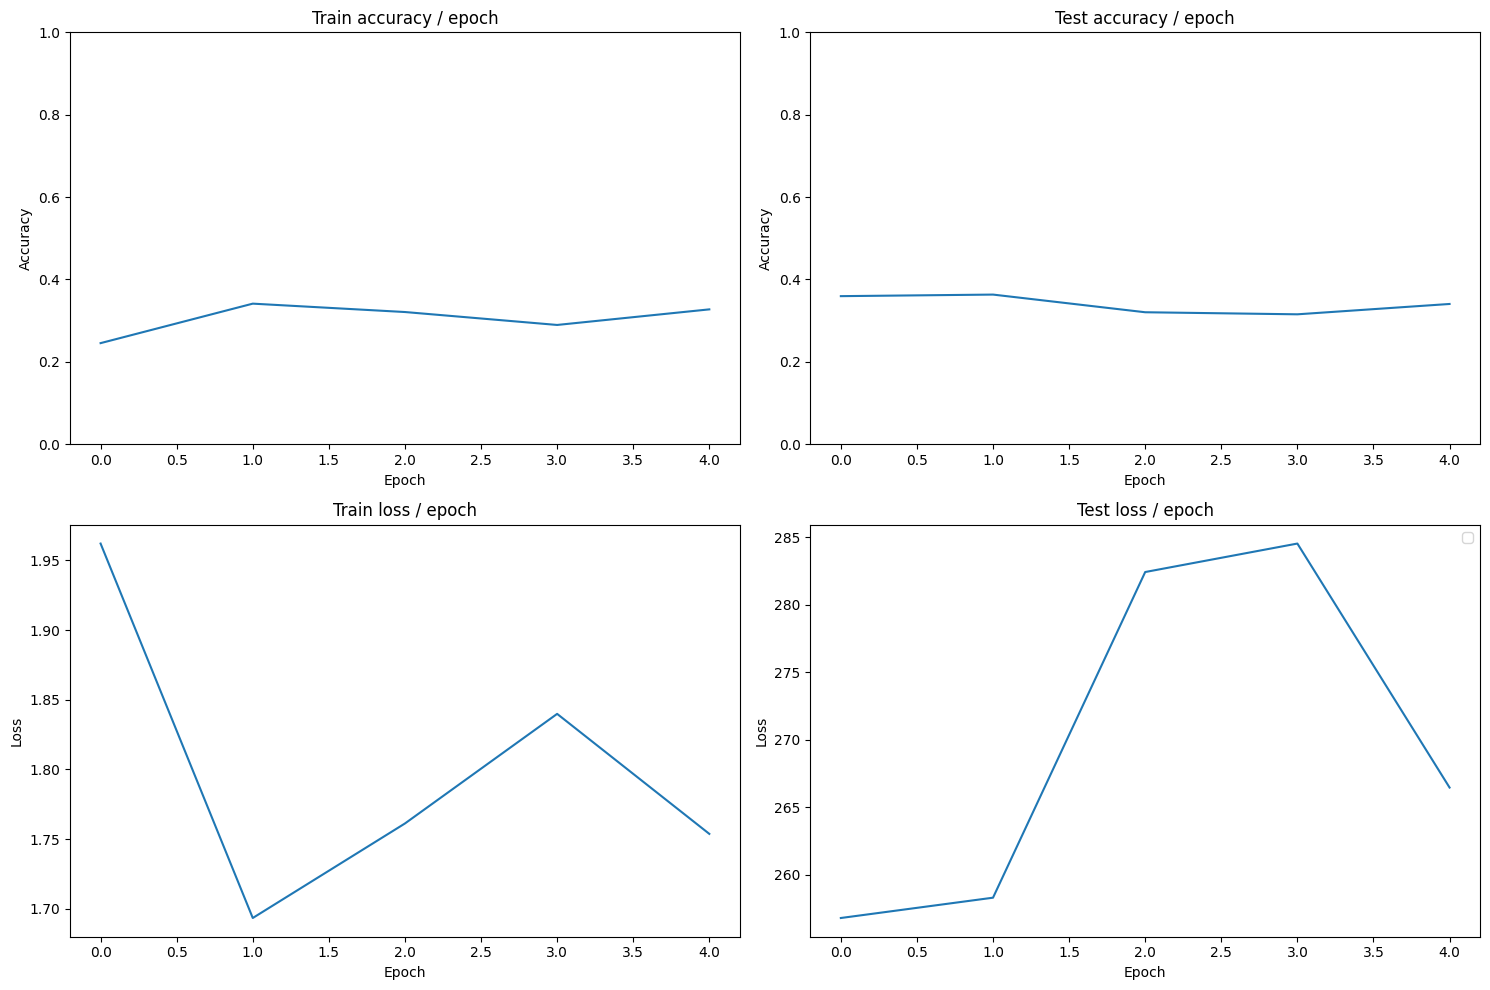

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

ax[0].plot(stats_vit[0])
ax[1].plot(stats_vit[1])
ax[2].plot(stats_vit[2])
ax[3].plot(stats_vit[3])

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 1])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 1])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("stats_vit.pdf", dpi=100, bbox_inches="tight")
plt.show()

c) redo the training but with the ViT-S pretrained on ImageNet

In [36]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10).cuda()
stats_pretrained = main(model=model, epochs=5, tqdm_batch=True)

  0%|                        | 0/938 [00:00<?, ?it/s]

  0%|                          | 0/5 [00:00<?, ?it/s]

  0%|                | 1/938 [00:00<09:29,  1.64it/s]

  0%|                | 2/938 [00:01<08:58,  1.74it/s]

  0%|                | 3/938 [00:01<08:48,  1.77it/s]

  0%|                | 4/938 [00:02<08:43,  1.78it/s]

  1%|                | 5/938 [00:02<08:40,  1.79it/s]

  1%|                | 6/938 [00:03<08:38,  1.80it/s]

  1%|                | 7/938 [00:03<08:36,  1.80it/s]

  1%|▏               | 8/938 [00:04<08:35,  1.80it/s]

  1%|▏               | 9/938 [00:05<08:34,  1.80it/s]

  1%|▏              | 10/938 [00:05<08:33,  1.81it/s]

  1%|▏              | 11/938 [00:06<08:33,  1.81it/s]

  1%|▏              | 12/938 [00:06<08:32,  1.81it/s]

  1%|▏              | 13/938 [00:07<08:31,  1.81it/s]

  1%|▏              | 14/938 [00:07<08:31,  1.81it/s]

  2%|▏              | 15/938 [00:08<08:30,  1.81it/s]

  2%|▎              | 16/938 [00:08<08:29,  1.81it/s]

  2%|▎              | 17/938 [00:09<08:29,  1.81it/s]

  2%|▎              | 18/938 [00:10<08:29,  1.81it/s]

  2%|▎              | 19/938 [00:10<08:28,  1.81it/s]

  2%|▎              | 20/938 [00:11<08:28,  1.81it/s]

  2%|▎              | 21/938 [00:11<08:27,  1.81it/s]

  2%|▎              | 22/938 [00:12<08:27,  1.81it/s]

  2%|▎              | 23/938 [00:12<08:26,  1.81it/s]

  3%|▍              | 24/938 [00:13<08:26,  1.81it/s]

  3%|▍              | 25/938 [00:13<08:26,  1.80it/s]

  3%|▍              | 26/938 [00:14<08:25,  1.80it/s]

  3%|▍              | 27/938 [00:14<08:24,  1.80it/s]

  3%|▍              | 28/938 [00:15<08:24,  1.80it/s]

  3%|▍              | 29/938 [00:16<08:23,  1.81it/s]

  3%|▍              | 30/938 [00:16<08:22,  1.81it/s]

  3%|▍              | 31/938 [00:17<08:22,  1.80it/s]

  3%|▌              | 32/938 [00:17<08:22,  1.80it/s]

  4%|▌              | 33/938 [00:18<08:21,  1.80it/s]

  4%|▌              | 34/938 [00:18<08:21,  1.80it/s]

  4%|▌              | 35/938 [00:19<08:21,  1.80it/s]

  4%|▌              | 36/938 [00:19<08:20,  1.80it/s]

  4%|▌              | 37/938 [00:20<08:19,  1.80it/s]

  4%|▌              | 38/938 [00:21<08:19,  1.80it/s]

  4%|▌              | 39/938 [00:21<08:18,  1.80it/s]

  4%|▋              | 40/938 [00:22<08:18,  1.80it/s]

  4%|▋              | 41/938 [00:22<08:17,  1.80it/s]

  4%|▋              | 42/938 [00:23<08:22,  1.78it/s]

  5%|▋              | 43/938 [00:23<08:20,  1.79it/s]

  5%|▋              | 44/938 [00:24<08:18,  1.79it/s]

  5%|▋              | 45/938 [00:25<08:17,  1.80it/s]

  5%|▋              | 46/938 [00:25<08:16,  1.80it/s]

  5%|▊              | 47/938 [00:26<08:15,  1.80it/s]

  5%|▊              | 48/938 [00:26<08:14,  1.80it/s]

  5%|▊              | 49/938 [00:27<08:14,  1.80it/s]

  5%|▊              | 50/938 [00:27<08:13,  1.80it/s]

  5%|▊              | 51/938 [00:28<08:12,  1.80it/s]

  6%|▊              | 52/938 [00:28<08:12,  1.80it/s]

  6%|▊              | 53/938 [00:29<08:11,  1.80it/s]

  6%|▊              | 54/938 [00:30<08:11,  1.80it/s]

  6%|▉              | 55/938 [00:30<08:10,  1.80it/s]

  6%|▉              | 56/938 [00:31<08:09,  1.80it/s]

  6%|▉              | 57/938 [00:31<08:09,  1.80it/s]

  6%|▉              | 58/938 [00:32<08:08,  1.80it/s]

  6%|▉              | 59/938 [00:32<08:08,  1.80it/s]

  6%|▉              | 60/938 [00:33<08:07,  1.80it/s]

  7%|▉              | 61/938 [00:33<08:07,  1.80it/s]

  7%|▉              | 62/938 [00:34<08:06,  1.80it/s]

  7%|█              | 63/938 [00:35<08:06,  1.80it/s]

  7%|█              | 64/938 [00:35<08:05,  1.80it/s]

  7%|█              | 65/938 [00:36<08:04,  1.80it/s]

  7%|█              | 66/938 [00:36<08:04,  1.80it/s]

  7%|█              | 67/938 [00:37<08:04,  1.80it/s]

  7%|█              | 68/938 [00:37<08:03,  1.80it/s]

  7%|█              | 69/938 [00:38<08:02,  1.80it/s]

  7%|█              | 70/938 [00:38<08:02,  1.80it/s]

  8%|█▏             | 71/938 [00:39<08:02,  1.80it/s]

  8%|█▏             | 72/938 [00:40<08:01,  1.80it/s]

  8%|█▏             | 73/938 [00:40<08:01,  1.80it/s]

  8%|█▏             | 74/938 [00:41<08:00,  1.80it/s]

  8%|█▏             | 75/938 [00:41<07:59,  1.80it/s]

  8%|█▏             | 76/938 [00:42<07:59,  1.80it/s]

  8%|█▏             | 77/938 [00:42<07:59,  1.80it/s]

  8%|█▏             | 78/938 [00:43<07:59,  1.80it/s]

  8%|█▎             | 79/938 [00:43<07:58,  1.80it/s]

  9%|█▎             | 80/938 [00:44<07:57,  1.80it/s]

  9%|█▎             | 81/938 [00:45<07:56,  1.80it/s]

  9%|█▎             | 82/938 [00:45<07:56,  1.80it/s]

  9%|█▎             | 83/938 [00:46<07:55,  1.80it/s]

  9%|█▎             | 84/938 [00:46<07:55,  1.80it/s]

  9%|█▎             | 85/938 [00:47<07:54,  1.80it/s]

  9%|█▍             | 86/938 [00:47<07:54,  1.80it/s]

  9%|█▍             | 87/938 [00:48<07:53,  1.80it/s]

  9%|█▍             | 88/938 [00:48<07:53,  1.80it/s]

  9%|█▍             | 89/938 [00:49<07:52,  1.80it/s]

 10%|█▍             | 90/938 [00:50<07:52,  1.80it/s]

 10%|█▍             | 91/938 [00:50<07:51,  1.79it/s]

 10%|█▍             | 92/938 [00:51<07:51,  1.80it/s]

 10%|█▍             | 93/938 [00:51<07:50,  1.80it/s]

 10%|█▌             | 94/938 [00:52<07:49,  1.80it/s]

 10%|█▌             | 95/938 [00:52<07:49,  1.80it/s]

 10%|█▌             | 96/938 [00:53<07:49,  1.80it/s]

 10%|█▌             | 97/938 [00:53<07:48,  1.80it/s]

 10%|█▌             | 98/938 [00:54<07:48,  1.79it/s]

 11%|█▌             | 99/938 [00:55<07:47,  1.79it/s]

 11%|█▍            | 100/938 [00:55<07:47,  1.79it/s]

 11%|█▌            | 101/938 [00:56<07:46,  1.79it/s]

 11%|█▌            | 102/938 [00:56<07:45,  1.79it/s]

 11%|█▌            | 103/938 [00:57<07:45,  1.79it/s]

 11%|█▌            | 104/938 [00:57<07:44,  1.80it/s]

 11%|█▌            | 105/938 [00:58<07:44,  1.79it/s]

 11%|█▌            | 106/938 [00:58<07:43,  1.79it/s]

 11%|█▌            | 107/938 [00:59<07:43,  1.79it/s]

 12%|█▌            | 108/938 [01:00<07:42,  1.79it/s]

 12%|█▋            | 109/938 [01:00<07:41,  1.80it/s]

 12%|█▋            | 110/938 [01:01<07:41,  1.80it/s]

 12%|█▋            | 111/938 [01:01<07:40,  1.80it/s]

 12%|█▋            | 112/938 [01:02<07:40,  1.79it/s]

 12%|█▋            | 113/938 [01:02<07:39,  1.79it/s]

 12%|█▋            | 114/938 [01:03<07:39,  1.79it/s]

 12%|█▋            | 115/938 [01:03<07:39,  1.79it/s]

 12%|█▋            | 116/938 [01:04<07:38,  1.79it/s]

 12%|█▋            | 117/938 [01:05<07:37,  1.79it/s]

 13%|█▊            | 118/938 [01:05<07:37,  1.79it/s]

 13%|█▊            | 119/938 [01:06<07:36,  1.79it/s]

 13%|█▊            | 120/938 [01:06<07:35,  1.79it/s]

 13%|█▊            | 121/938 [01:07<07:35,  1.79it/s]

 13%|█▊            | 122/938 [01:07<07:35,  1.79it/s]

 13%|█▊            | 123/938 [01:08<07:34,  1.79it/s]

 13%|█▊            | 124/938 [01:08<07:34,  1.79it/s]

 13%|█▊            | 125/938 [01:09<07:33,  1.79it/s]

 13%|█▉            | 126/938 [01:10<07:33,  1.79it/s]

 14%|█▉            | 127/938 [01:10<07:32,  1.79it/s]

 14%|█▉            | 128/938 [01:11<07:31,  1.79it/s]

 14%|█▉            | 129/938 [01:11<07:31,  1.79it/s]

 14%|█▉            | 130/938 [01:12<07:30,  1.79it/s]

 14%|█▉            | 131/938 [01:12<07:30,  1.79it/s]

 14%|█▉            | 132/938 [01:13<07:29,  1.79it/s]

 14%|█▉            | 133/938 [01:13<07:29,  1.79it/s]

 14%|██            | 134/938 [01:14<07:28,  1.79it/s]

 14%|██            | 135/938 [01:15<07:28,  1.79it/s]

 14%|██            | 136/938 [01:15<07:27,  1.79it/s]

 15%|██            | 137/938 [01:16<07:26,  1.79it/s]

 15%|██            | 138/938 [01:16<07:26,  1.79it/s]

 15%|██            | 139/938 [01:17<07:25,  1.79it/s]

 15%|██            | 140/938 [01:17<07:24,  1.79it/s]

 15%|██            | 141/938 [01:18<07:24,  1.79it/s]

 15%|██            | 142/938 [01:19<07:24,  1.79it/s]

 15%|██▏           | 143/938 [01:19<07:23,  1.79it/s]

 15%|██▏           | 144/938 [01:20<07:22,  1.79it/s]

 15%|██▏           | 145/938 [01:20<07:22,  1.79it/s]

 16%|██▏           | 146/938 [01:21<07:21,  1.79it/s]

 16%|██▏           | 147/938 [01:21<07:21,  1.79it/s]

 16%|██▏           | 148/938 [01:22<07:20,  1.79it/s]

 16%|██▏           | 149/938 [01:22<07:20,  1.79it/s]

 16%|██▏           | 150/938 [01:23<07:19,  1.79it/s]

 16%|██▎           | 151/938 [01:24<07:18,  1.79it/s]

 16%|██▎           | 152/938 [01:24<07:18,  1.79it/s]

 16%|██▎           | 153/938 [01:25<07:18,  1.79it/s]

 16%|██▎           | 154/938 [01:25<07:17,  1.79it/s]

 17%|██▎           | 155/938 [01:26<07:28,  1.75it/s]

 17%|██▎           | 156/938 [01:26<07:24,  1.76it/s]

 17%|██▎           | 157/938 [01:27<07:22,  1.77it/s]

 17%|██▎           | 158/938 [01:28<07:19,  1.77it/s]

 17%|██▎           | 159/938 [01:28<07:17,  1.78it/s]

 17%|██▍           | 160/938 [01:29<07:16,  1.78it/s]

 17%|██▍           | 161/938 [01:29<07:15,  1.79it/s]

 17%|██▍           | 162/938 [01:30<07:14,  1.79it/s]

 17%|██▍           | 163/938 [01:30<07:13,  1.79it/s]

 17%|██▍           | 164/938 [01:31<07:12,  1.79it/s]

 18%|██▍           | 165/938 [01:31<07:13,  1.78it/s]

 18%|██▍           | 166/938 [01:32<07:12,  1.78it/s]

 18%|██▍           | 167/938 [01:33<07:11,  1.79it/s]

 18%|██▌           | 168/938 [01:33<07:10,  1.79it/s]

 18%|██▌           | 169/938 [01:34<07:09,  1.79it/s]

 18%|██▌           | 170/938 [01:34<07:08,  1.79it/s]

 18%|██▌           | 171/938 [01:35<07:15,  1.76it/s]

 18%|██▌           | 172/938 [01:35<07:12,  1.77it/s]

 18%|██▌           | 173/938 [01:36<07:10,  1.78it/s]

 19%|██▌           | 174/938 [01:36<07:08,  1.78it/s]

 19%|██▌           | 175/938 [01:37<07:07,  1.79it/s]

 19%|██▋           | 176/938 [01:38<07:06,  1.79it/s]

 19%|██▋           | 177/938 [01:38<07:05,  1.79it/s]

 19%|██▋           | 178/938 [01:39<07:04,  1.79it/s]

 19%|██▋           | 179/938 [01:39<07:03,  1.79it/s]

 19%|██▋           | 180/938 [01:40<07:02,  1.79it/s]

 19%|██▋           | 181/938 [01:40<07:02,  1.79it/s]

 19%|██▋           | 182/938 [01:41<07:01,  1.79it/s]

 20%|██▋           | 183/938 [01:41<07:04,  1.78it/s]

 20%|██▋           | 184/938 [01:42<07:06,  1.77it/s]

 20%|██▊           | 185/938 [01:43<07:07,  1.76it/s]

 20%|██▊           | 186/938 [01:43<07:07,  1.76it/s]

 20%|██▊           | 187/938 [01:44<07:08,  1.75it/s]

 20%|██▊           | 188/938 [01:44<07:08,  1.75it/s]

 20%|██▊           | 189/938 [01:45<07:04,  1.77it/s]

 20%|██▊           | 190/938 [01:45<07:01,  1.77it/s]

 20%|██▊           | 191/938 [01:46<06:59,  1.78it/s]

 20%|██▊           | 192/938 [01:47<06:58,  1.78it/s]

 21%|██▉           | 193/938 [01:47<06:56,  1.79it/s]

 21%|██▉           | 194/938 [01:48<06:55,  1.79it/s]

 21%|██▉           | 195/938 [01:48<06:58,  1.78it/s]

 21%|██▉           | 196/938 [01:49<06:56,  1.78it/s]

 21%|██▉           | 197/938 [01:49<06:54,  1.79it/s]

 21%|██▉           | 198/938 [01:50<06:53,  1.79it/s]

 21%|██▉           | 199/938 [01:51<06:52,  1.79it/s]

 21%|██▉           | 200/938 [01:51<06:51,  1.79it/s]

 21%|███           | 201/938 [01:52<06:51,  1.79it/s]

 22%|███           | 202/938 [01:52<06:50,  1.79it/s]

 22%|███           | 203/938 [01:53<06:49,  1.80it/s]

 22%|███           | 204/938 [01:53<06:48,  1.79it/s]

 22%|███           | 205/938 [01:54<06:48,  1.79it/s]

 22%|███           | 206/938 [01:54<06:47,  1.79it/s]

 22%|███           | 207/938 [01:55<06:47,  1.79it/s]

 22%|███           | 208/938 [01:56<06:46,  1.79it/s]

 22%|███           | 209/938 [01:56<06:46,  1.80it/s]

 22%|███▏          | 210/938 [01:57<06:45,  1.80it/s]

 22%|███▏          | 211/938 [01:57<06:44,  1.80it/s]

 23%|███▏          | 212/938 [01:58<06:44,  1.80it/s]

 23%|███▏          | 213/938 [01:58<06:43,  1.80it/s]

 23%|███▏          | 214/938 [01:59<06:42,  1.80it/s]

 23%|███▏          | 215/938 [01:59<06:42,  1.80it/s]

 23%|███▏          | 216/938 [02:00<06:41,  1.80it/s]

 23%|███▏          | 217/938 [02:01<06:41,  1.80it/s]

 23%|███▎          | 218/938 [02:01<06:40,  1.80it/s]

 23%|███▎          | 219/938 [02:02<06:40,  1.80it/s]

 23%|███▎          | 220/938 [02:02<06:39,  1.80it/s]

 24%|███▎          | 221/938 [02:03<06:38,  1.80it/s]

 24%|███▎          | 222/938 [02:03<06:38,  1.80it/s]

 24%|███▎          | 223/938 [02:04<06:38,  1.80it/s]

 24%|███▎          | 224/938 [02:04<06:37,  1.80it/s]

 24%|███▎          | 225/938 [02:05<06:37,  1.80it/s]

 24%|███▎          | 226/938 [02:06<06:36,  1.80it/s]

 24%|███▍          | 227/938 [02:06<06:35,  1.80it/s]

 24%|███▍          | 228/938 [02:07<06:38,  1.78it/s]

 24%|███▍          | 229/938 [02:07<06:40,  1.77it/s]

 25%|███▍          | 230/938 [02:08<06:41,  1.76it/s]

 25%|███▍          | 231/938 [02:08<06:41,  1.76it/s]

 25%|███▍          | 232/938 [02:09<06:42,  1.76it/s]

 25%|███▍          | 233/938 [02:10<06:42,  1.75it/s]

 25%|███▍          | 234/938 [02:10<06:42,  1.75it/s]

 25%|███▌          | 235/938 [02:11<06:41,  1.75it/s]

 25%|███▌          | 236/938 [02:11<06:41,  1.75it/s]

 25%|███▌          | 237/938 [02:12<06:40,  1.75it/s]

 25%|███▌          | 238/938 [02:12<06:39,  1.75it/s]

 25%|███▌          | 239/938 [02:13<06:39,  1.75it/s]

 26%|███▌          | 240/938 [02:14<06:39,  1.75it/s]

 26%|███▌          | 241/938 [02:14<06:38,  1.75it/s]

 26%|███▌          | 242/938 [02:15<06:38,  1.75it/s]

 26%|███▋          | 243/938 [02:15<06:37,  1.75it/s]

 26%|███▋          | 244/938 [02:16<06:34,  1.76it/s]

 26%|███▋          | 245/938 [02:16<06:31,  1.77it/s]

 26%|███▋          | 246/938 [02:17<06:29,  1.78it/s]

 26%|███▋          | 247/938 [02:17<06:27,  1.78it/s]

 26%|███▋          | 248/938 [02:18<06:25,  1.79it/s]

 27%|███▋          | 249/938 [02:19<06:24,  1.79it/s]

 27%|███▋          | 250/938 [02:19<06:23,  1.79it/s]

 27%|███▋          | 251/938 [02:20<06:22,  1.80it/s]

 27%|███▊          | 252/938 [02:20<06:21,  1.80it/s]

 27%|███▊          | 253/938 [02:21<06:21,  1.80it/s]

 27%|███▊          | 254/938 [02:21<06:20,  1.80it/s]

 27%|███▊          | 255/938 [02:22<06:19,  1.80it/s]

 27%|███▊          | 256/938 [02:22<06:19,  1.80it/s]

 27%|███▊          | 257/938 [02:23<06:18,  1.80it/s]

 28%|███▊          | 258/938 [02:24<06:18,  1.80it/s]

 28%|███▊          | 259/938 [02:24<06:17,  1.80it/s]

 28%|███▉          | 260/938 [02:25<06:16,  1.80it/s]

 28%|███▉          | 261/938 [02:25<06:16,  1.80it/s]

 28%|███▉          | 262/938 [02:26<06:16,  1.80it/s]

 28%|███▉          | 263/938 [02:26<06:15,  1.80it/s]

 28%|███▉          | 264/938 [02:27<06:15,  1.80it/s]

 28%|███▉          | 265/938 [02:27<06:14,  1.80it/s]

 28%|███▉          | 266/938 [02:28<06:14,  1.80it/s]

 28%|███▉          | 267/938 [02:29<06:13,  1.80it/s]

 29%|████          | 268/938 [02:29<06:12,  1.80it/s]

 29%|████          | 269/938 [02:30<06:12,  1.80it/s]

 29%|████          | 270/938 [02:30<06:11,  1.80it/s]

 29%|████          | 271/938 [02:31<06:10,  1.80it/s]

 29%|████          | 272/938 [02:31<06:10,  1.80it/s]

 29%|████          | 273/938 [02:32<06:09,  1.80it/s]

 29%|████          | 274/938 [02:32<06:09,  1.80it/s]

 29%|████          | 275/938 [02:33<06:10,  1.79it/s]

 29%|████          | 276/938 [02:34<06:09,  1.79it/s]

 30%|████▏         | 277/938 [02:34<06:08,  1.79it/s]

 30%|████▏         | 278/938 [02:35<06:07,  1.80it/s]

 30%|████▏         | 279/938 [02:35<06:06,  1.80it/s]

 30%|████▏         | 280/938 [02:36<06:06,  1.80it/s]

 30%|████▏         | 281/938 [02:36<06:05,  1.80it/s]

 30%|████▏         | 282/938 [02:37<06:05,  1.80it/s]

 30%|████▏         | 283/938 [02:38<06:04,  1.80it/s]

 30%|████▏         | 284/938 [02:38<06:03,  1.80it/s]

 30%|████▎         | 285/938 [02:39<06:03,  1.80it/s]

 30%|████▎         | 286/938 [02:39<06:02,  1.80it/s]

 31%|████▎         | 287/938 [02:40<06:02,  1.80it/s]

 31%|████▎         | 288/938 [02:40<06:01,  1.80it/s]

 31%|████▎         | 289/938 [02:41<06:01,  1.80it/s]

 31%|████▎         | 290/938 [02:41<06:00,  1.80it/s]

 31%|████▎         | 291/938 [02:42<05:59,  1.80it/s]

 31%|████▎         | 292/938 [02:43<05:59,  1.80it/s]

 31%|████▎         | 293/938 [02:43<05:58,  1.80it/s]

 31%|████▍         | 294/938 [02:44<05:58,  1.80it/s]

 31%|████▍         | 295/938 [02:44<05:57,  1.80it/s]

 32%|████▍         | 296/938 [02:45<05:56,  1.80it/s]

 32%|████▍         | 297/938 [02:45<05:56,  1.80it/s]

 32%|████▍         | 298/938 [02:46<05:55,  1.80it/s]

 32%|████▍         | 299/938 [02:46<05:55,  1.80it/s]

 32%|████▍         | 300/938 [02:47<05:54,  1.80it/s]

 32%|████▍         | 301/938 [02:48<05:53,  1.80it/s]

 32%|████▌         | 302/938 [02:48<05:53,  1.80it/s]

 32%|████▌         | 303/938 [02:49<05:53,  1.80it/s]

 32%|████▌         | 304/938 [02:49<05:52,  1.80it/s]

 33%|████▌         | 305/938 [02:50<05:51,  1.80it/s]

 33%|████▌         | 306/938 [02:50<05:51,  1.80it/s]

 33%|████▌         | 307/938 [02:51<05:50,  1.80it/s]

 33%|████▌         | 308/938 [02:51<05:50,  1.80it/s]

 33%|████▌         | 309/938 [02:52<05:49,  1.80it/s]

 33%|████▋         | 310/938 [02:53<05:49,  1.80it/s]

 33%|████▋         | 311/938 [02:53<05:48,  1.80it/s]

 33%|████▋         | 312/938 [02:54<05:47,  1.80it/s]

 33%|████▋         | 313/938 [02:54<05:47,  1.80it/s]

 33%|████▋         | 314/938 [02:55<05:46,  1.80it/s]

 34%|████▋         | 315/938 [02:55<05:46,  1.80it/s]

 34%|████▋         | 316/938 [02:56<05:45,  1.80it/s]

 34%|████▋         | 317/938 [02:56<05:45,  1.80it/s]

 34%|████▋         | 318/938 [02:57<05:44,  1.80it/s]

 34%|████▊         | 319/938 [02:58<05:44,  1.80it/s]

 34%|████▊         | 320/938 [02:58<05:44,  1.80it/s]

 34%|████▊         | 321/938 [02:59<05:43,  1.80it/s]

 34%|████▊         | 322/938 [02:59<05:42,  1.80it/s]

 34%|████▊         | 323/938 [03:00<05:42,  1.80it/s]

 35%|████▊         | 324/938 [03:00<05:41,  1.80it/s]

 35%|████▊         | 325/938 [03:01<05:41,  1.80it/s]

 35%|████▊         | 326/938 [03:01<05:40,  1.80it/s]

 35%|████▉         | 327/938 [03:02<05:39,  1.80it/s]

 35%|████▉         | 328/938 [03:03<05:39,  1.80it/s]

 35%|████▉         | 329/938 [03:03<05:38,  1.80it/s]

 35%|████▉         | 330/938 [03:04<05:38,  1.80it/s]

 35%|████▉         | 331/938 [03:04<05:37,  1.80it/s]

 35%|████▉         | 332/938 [03:05<05:36,  1.80it/s]

 36%|████▉         | 333/938 [03:05<05:36,  1.80it/s]

 36%|████▉         | 334/938 [03:06<05:35,  1.80it/s]

 36%|█████         | 335/938 [03:06<05:35,  1.80it/s]

 36%|█████         | 336/938 [03:07<05:34,  1.80it/s]

 36%|█████         | 337/938 [03:08<05:34,  1.80it/s]

 36%|█████         | 338/938 [03:08<05:33,  1.80it/s]

 36%|█████         | 339/938 [03:09<05:32,  1.80it/s]

 36%|█████         | 340/938 [03:09<05:32,  1.80it/s]

 36%|█████         | 341/938 [03:10<05:31,  1.80it/s]

 36%|█████         | 342/938 [03:10<05:31,  1.80it/s]

 37%|█████         | 343/938 [03:11<05:30,  1.80it/s]

 37%|█████▏        | 344/938 [03:11<05:30,  1.80it/s]

 37%|█████▏        | 345/938 [03:12<05:29,  1.80it/s]

 37%|█████▏        | 346/938 [03:13<05:29,  1.80it/s]

 37%|█████▏        | 347/938 [03:13<05:28,  1.80it/s]

 37%|█████▏        | 348/938 [03:14<05:27,  1.80it/s]

 37%|█████▏        | 349/938 [03:14<05:27,  1.80it/s]

 37%|█████▏        | 350/938 [03:15<05:26,  1.80it/s]

 37%|█████▏        | 351/938 [03:15<05:26,  1.80it/s]

 38%|█████▎        | 352/938 [03:16<05:25,  1.80it/s]

 38%|█████▎        | 353/938 [03:16<05:25,  1.80it/s]

 38%|█████▎        | 354/938 [03:17<05:24,  1.80it/s]

 38%|█████▎        | 355/938 [03:18<05:24,  1.80it/s]

 38%|█████▎        | 356/938 [03:18<05:24,  1.79it/s]

 38%|█████▎        | 357/938 [03:19<05:24,  1.79it/s]

 38%|█████▎        | 358/938 [03:19<05:23,  1.79it/s]

 38%|█████▎        | 359/938 [03:20<05:22,  1.79it/s]

 38%|█████▎        | 360/938 [03:20<05:22,  1.79it/s]

 38%|█████▍        | 361/938 [03:21<05:21,  1.80it/s]

 39%|█████▍        | 362/938 [03:21<05:20,  1.80it/s]

 39%|█████▍        | 363/938 [03:22<05:19,  1.80it/s]

 39%|█████▍        | 364/938 [03:23<05:19,  1.80it/s]

 39%|█████▍        | 365/938 [03:23<05:18,  1.80it/s]

 39%|█████▍        | 366/938 [03:24<05:17,  1.80it/s]

 39%|█████▍        | 367/938 [03:24<05:17,  1.80it/s]

 39%|█████▍        | 368/938 [03:25<05:16,  1.80it/s]

 39%|█████▌        | 369/938 [03:25<05:16,  1.80it/s]

 39%|█████▌        | 370/938 [03:26<05:15,  1.80it/s]

 40%|█████▌        | 371/938 [03:26<05:15,  1.80it/s]

 40%|█████▌        | 372/938 [03:27<05:14,  1.80it/s]

 40%|█████▌        | 373/938 [03:28<05:13,  1.80it/s]

 40%|█████▌        | 374/938 [03:28<05:13,  1.80it/s]

 40%|█████▌        | 375/938 [03:29<05:12,  1.80it/s]

 40%|█████▌        | 376/938 [03:29<05:12,  1.80it/s]

 40%|█████▋        | 377/938 [03:30<05:11,  1.80it/s]

 40%|█████▋        | 378/938 [03:30<05:11,  1.80it/s]

 40%|█████▋        | 379/938 [03:31<05:10,  1.80it/s]

 41%|█████▋        | 380/938 [03:31<05:10,  1.80it/s]

 41%|█████▋        | 381/938 [03:32<05:09,  1.80it/s]

 41%|█████▋        | 382/938 [03:33<05:08,  1.80it/s]

 41%|█████▋        | 383/938 [03:33<05:08,  1.80it/s]

 41%|█████▋        | 384/938 [03:34<05:07,  1.80it/s]

 41%|█████▋        | 385/938 [03:34<05:07,  1.80it/s]

 41%|█████▊        | 386/938 [03:35<05:06,  1.80it/s]

 41%|█████▊        | 387/938 [03:35<05:06,  1.80it/s]

 41%|█████▊        | 388/938 [03:36<05:05,  1.80it/s]

 41%|█████▊        | 389/938 [03:36<05:04,  1.80it/s]

 42%|█████▊        | 390/938 [03:37<05:04,  1.80it/s]

 42%|█████▊        | 391/938 [03:38<05:03,  1.80it/s]

 42%|█████▊        | 392/938 [03:38<05:03,  1.80it/s]

 42%|█████▊        | 393/938 [03:39<05:02,  1.80it/s]

 42%|█████▉        | 394/938 [03:39<05:01,  1.80it/s]

 42%|█████▉        | 395/938 [03:40<05:02,  1.80it/s]

 42%|█████▉        | 396/938 [03:40<05:01,  1.80it/s]

 42%|█████▉        | 397/938 [03:41<05:00,  1.80it/s]

 42%|█████▉        | 398/938 [03:41<05:00,  1.80it/s]

 43%|█████▉        | 399/938 [03:42<04:59,  1.80it/s]

 43%|█████▉        | 400/938 [03:43<04:58,  1.80it/s]

 43%|█████▉        | 401/938 [03:43<04:58,  1.80it/s]

 43%|██████        | 402/938 [03:44<04:57,  1.80it/s]

 43%|██████        | 403/938 [03:44<04:57,  1.80it/s]

 43%|██████        | 404/938 [03:45<04:58,  1.79it/s]

 43%|██████        | 405/938 [03:45<04:57,  1.79it/s]

 43%|██████        | 406/938 [03:46<04:56,  1.79it/s]

 43%|██████        | 407/938 [03:46<04:55,  1.80it/s]

 43%|██████        | 408/938 [03:47<04:54,  1.80it/s]

 44%|██████        | 409/938 [03:48<04:54,  1.80it/s]

 44%|██████        | 410/938 [03:48<04:53,  1.80it/s]

 44%|██████▏       | 411/938 [03:49<04:53,  1.79it/s]

 44%|██████▏       | 412/938 [03:49<04:52,  1.80it/s]

 44%|██████▏       | 413/938 [03:50<04:51,  1.80it/s]

 44%|██████▏       | 414/938 [03:50<04:51,  1.80it/s]

 44%|██████▏       | 415/938 [03:51<04:50,  1.80it/s]

 44%|██████▏       | 416/938 [03:51<04:49,  1.80it/s]

 44%|██████▏       | 417/938 [03:52<04:49,  1.80it/s]

 45%|██████▏       | 418/938 [03:53<04:48,  1.80it/s]

 45%|██████▎       | 419/938 [03:53<04:48,  1.80it/s]

 45%|██████▎       | 420/938 [03:54<04:47,  1.80it/s]

 45%|██████▎       | 421/938 [03:54<04:47,  1.80it/s]

 45%|██████▎       | 422/938 [03:55<04:46,  1.80it/s]

 45%|██████▎       | 423/938 [03:55<04:46,  1.80it/s]

 45%|██████▎       | 424/938 [03:56<04:45,  1.80it/s]

 45%|██████▎       | 425/938 [03:56<04:46,  1.79it/s]

 45%|██████▎       | 426/938 [03:57<04:45,  1.79it/s]

 46%|██████▎       | 427/938 [03:58<04:44,  1.80it/s]

 46%|██████▍       | 428/938 [03:58<04:43,  1.80it/s]

 46%|██████▍       | 429/938 [03:59<04:43,  1.80it/s]

 46%|██████▍       | 430/938 [03:59<04:42,  1.80it/s]

 46%|██████▍       | 431/938 [04:00<04:41,  1.80it/s]

 46%|██████▍       | 432/938 [04:00<04:40,  1.80it/s]

 46%|██████▍       | 433/938 [04:01<04:40,  1.80it/s]

 46%|██████▍       | 434/938 [04:01<04:39,  1.80it/s]

 46%|██████▍       | 435/938 [04:02<04:39,  1.80it/s]

 46%|██████▌       | 436/938 [04:03<04:38,  1.80it/s]

 47%|██████▌       | 437/938 [04:03<04:38,  1.80it/s]

 47%|██████▌       | 438/938 [04:04<04:37,  1.80it/s]

 47%|██████▌       | 439/938 [04:04<04:37,  1.80it/s]

 47%|██████▌       | 440/938 [04:05<04:36,  1.80it/s]

 47%|██████▌       | 441/938 [04:05<04:35,  1.80it/s]

 47%|██████▌       | 442/938 [04:06<04:35,  1.80it/s]

 47%|██████▌       | 443/938 [04:06<04:34,  1.80it/s]

 47%|██████▋       | 444/938 [04:07<04:34,  1.80it/s]

 47%|██████▋       | 445/938 [04:08<04:33,  1.80it/s]

 48%|██████▋       | 446/938 [04:08<04:33,  1.80it/s]

 48%|██████▋       | 447/938 [04:09<04:32,  1.80it/s]

 48%|██████▋       | 448/938 [04:09<04:32,  1.80it/s]

 48%|██████▋       | 449/938 [04:10<04:31,  1.80it/s]

 48%|██████▋       | 450/938 [04:10<04:30,  1.80it/s]

 48%|██████▋       | 451/938 [04:11<04:31,  1.79it/s]

 48%|██████▋       | 452/938 [04:11<04:30,  1.80it/s]

 48%|██████▊       | 453/938 [04:12<04:30,  1.80it/s]

 48%|██████▊       | 454/938 [04:13<04:29,  1.80it/s]

 49%|██████▊       | 455/938 [04:13<04:28,  1.80it/s]

 49%|██████▊       | 456/938 [04:14<04:28,  1.80it/s]

 49%|██████▊       | 457/938 [04:14<04:27,  1.80it/s]

 49%|██████▊       | 458/938 [04:15<04:26,  1.80it/s]

 49%|██████▊       | 459/938 [04:15<04:26,  1.80it/s]

 49%|██████▊       | 460/938 [04:16<04:25,  1.80it/s]

 49%|██████▉       | 461/938 [04:16<04:25,  1.80it/s]

 49%|██████▉       | 462/938 [04:17<04:24,  1.80it/s]

 49%|██████▉       | 463/938 [04:18<04:24,  1.80it/s]

 49%|██████▉       | 464/938 [04:18<04:23,  1.80it/s]

 50%|██████▉       | 465/938 [04:19<04:23,  1.80it/s]

 50%|██████▉       | 466/938 [04:19<04:22,  1.80it/s]

 50%|██████▉       | 467/938 [04:20<04:21,  1.80it/s]

 50%|██████▉       | 468/938 [04:20<04:21,  1.80it/s]

 50%|███████       | 469/938 [04:21<04:22,  1.79it/s]

 50%|███████       | 470/938 [04:22<04:23,  1.78it/s]

 50%|███████       | 471/938 [04:22<04:21,  1.78it/s]

 50%|███████       | 472/938 [04:23<04:20,  1.79it/s]

 50%|███████       | 473/938 [04:23<04:21,  1.78it/s]

 51%|███████       | 474/938 [04:24<04:19,  1.79it/s]

 51%|███████       | 475/938 [04:24<04:18,  1.79it/s]

 51%|███████       | 476/938 [04:25<04:19,  1.78it/s]

 51%|███████       | 477/938 [04:25<04:19,  1.77it/s]

 51%|███████▏      | 478/938 [04:26<04:19,  1.77it/s]

 51%|███████▏      | 479/938 [04:27<04:19,  1.77it/s]

 51%|███████▏      | 480/938 [04:27<04:19,  1.76it/s]

 51%|███████▏      | 481/938 [04:28<04:19,  1.76it/s]

 51%|███████▏      | 482/938 [04:28<04:18,  1.76it/s]

 51%|███████▏      | 483/938 [04:29<04:18,  1.76it/s]

 52%|███████▏      | 484/938 [04:29<04:17,  1.76it/s]

 52%|███████▏      | 485/938 [04:30<04:17,  1.76it/s]

 52%|███████▎      | 486/938 [04:31<04:16,  1.76it/s]

 52%|███████▎      | 487/938 [04:31<04:16,  1.76it/s]

 52%|███████▎      | 488/938 [04:32<04:15,  1.76it/s]

 52%|███████▎      | 489/938 [04:32<04:15,  1.76it/s]

 52%|███████▎      | 490/938 [04:33<04:14,  1.76it/s]

 52%|███████▎      | 491/938 [04:33<04:14,  1.76it/s]

 52%|███████▎      | 492/938 [04:34<04:13,  1.76it/s]

 53%|███████▎      | 493/938 [04:35<04:12,  1.76it/s]

 53%|███████▎      | 494/938 [04:35<04:12,  1.76it/s]

 53%|███████▍      | 495/938 [04:36<04:11,  1.76it/s]

 53%|███████▍      | 496/938 [04:36<04:11,  1.76it/s]

 53%|███████▍      | 497/938 [04:37<04:10,  1.76it/s]

 53%|███████▍      | 498/938 [04:37<04:10,  1.76it/s]

 53%|███████▍      | 499/938 [04:38<04:09,  1.76it/s]

 53%|███████▍      | 500/938 [04:39<04:08,  1.76it/s]

 53%|███████▍      | 501/938 [04:39<04:08,  1.76it/s]

 54%|███████▍      | 502/938 [04:40<04:07,  1.76it/s]

 54%|███████▌      | 503/938 [04:40<04:07,  1.76it/s]

 54%|███████▌      | 504/938 [04:41<04:06,  1.76it/s]

 54%|███████▌      | 505/938 [04:41<04:06,  1.76it/s]

 54%|███████▌      | 506/938 [04:42<04:05,  1.76it/s]

 54%|███████▌      | 507/938 [04:42<04:03,  1.77it/s]

 54%|███████▌      | 508/938 [04:43<04:01,  1.78it/s]

 54%|███████▌      | 509/938 [04:44<04:00,  1.78it/s]

 54%|███████▌      | 510/938 [04:44<03:59,  1.79it/s]

 54%|███████▋      | 511/938 [04:45<03:58,  1.79it/s]

 55%|███████▋      | 512/938 [04:45<03:57,  1.79it/s]

 55%|███████▋      | 513/938 [04:46<03:56,  1.80it/s]

 55%|███████▋      | 514/938 [04:46<03:55,  1.80it/s]

 55%|███████▋      | 515/938 [04:47<03:55,  1.80it/s]

 55%|███████▋      | 516/938 [04:47<03:54,  1.80it/s]

 55%|███████▋      | 517/938 [04:48<03:54,  1.80it/s]

 55%|███████▋      | 518/938 [04:49<03:53,  1.80it/s]

 55%|███████▋      | 519/938 [04:49<03:52,  1.80it/s]

 55%|███████▊      | 520/938 [04:50<03:52,  1.80it/s]

 56%|███████▊      | 521/938 [04:50<03:57,  1.76it/s]

 56%|███████▊      | 522/938 [04:51<03:55,  1.77it/s]

 56%|███████▊      | 523/938 [04:51<03:57,  1.75it/s]

 56%|███████▊      | 524/938 [04:52<03:55,  1.76it/s]

 56%|███████▊      | 525/938 [04:53<03:52,  1.77it/s]

 56%|███████▊      | 526/938 [04:53<03:51,  1.78it/s]

 56%|███████▊      | 527/938 [04:54<03:50,  1.79it/s]

 56%|███████▉      | 528/938 [04:54<03:48,  1.79it/s]

 56%|███████▉      | 529/938 [04:55<03:47,  1.79it/s]

 57%|███████▉      | 530/938 [04:55<03:47,  1.80it/s]

 57%|███████▉      | 531/938 [04:56<03:46,  1.80it/s]

 57%|███████▉      | 532/938 [04:56<03:45,  1.80it/s]

 57%|███████▉      | 533/938 [04:57<03:45,  1.80it/s]

 57%|███████▉      | 534/938 [04:58<03:44,  1.80it/s]

 57%|███████▉      | 535/938 [04:58<03:43,  1.80it/s]

 57%|████████      | 536/938 [04:59<03:43,  1.80it/s]

 57%|████████      | 537/938 [04:59<03:42,  1.80it/s]

 57%|████████      | 538/938 [05:00<03:42,  1.80it/s]

 57%|████████      | 539/938 [05:00<03:41,  1.80it/s]

 58%|████████      | 540/938 [05:01<03:41,  1.80it/s]

 58%|████████      | 541/938 [05:01<03:40,  1.80it/s]

 58%|████████      | 542/938 [05:02<03:40,  1.80it/s]

 58%|████████      | 543/938 [05:03<03:39,  1.80it/s]

 58%|████████      | 544/938 [05:03<03:38,  1.80it/s]

 58%|████████▏     | 545/938 [05:04<03:38,  1.80it/s]

 58%|████████▏     | 546/938 [05:04<03:37,  1.80it/s]

 58%|████████▏     | 547/938 [05:05<03:37,  1.80it/s]

 58%|████████▏     | 548/938 [05:05<03:36,  1.80it/s]

 59%|████████▏     | 549/938 [05:06<03:36,  1.80it/s]

 59%|████████▏     | 550/938 [05:06<03:35,  1.80it/s]

 59%|████████▏     | 551/938 [05:07<03:35,  1.80it/s]

 59%|████████▏     | 552/938 [05:08<03:34,  1.80it/s]

 59%|████████▎     | 553/938 [05:08<03:33,  1.80it/s]

 59%|████████▎     | 554/938 [05:09<03:33,  1.80it/s]

 59%|████████▎     | 555/938 [05:09<03:32,  1.80it/s]

 59%|████████▎     | 556/938 [05:10<03:32,  1.80it/s]

 59%|████████▎     | 557/938 [05:10<03:31,  1.80it/s]

 59%|████████▎     | 558/938 [05:11<03:31,  1.80it/s]

 60%|████████▎     | 559/938 [05:11<03:31,  1.80it/s]

 60%|████████▎     | 560/938 [05:12<03:30,  1.80it/s]

 60%|████████▎     | 561/938 [05:13<03:34,  1.76it/s]

 60%|████████▍     | 562/938 [05:13<03:32,  1.77it/s]

 60%|████████▍     | 563/938 [05:14<03:30,  1.78it/s]

 60%|████████▍     | 564/938 [05:14<03:31,  1.77it/s]

 60%|████████▍     | 565/938 [05:15<03:30,  1.78it/s]

 60%|████████▍     | 566/938 [05:15<03:28,  1.78it/s]

 60%|████████▍     | 567/938 [05:16<03:27,  1.79it/s]

 61%|████████▍     | 568/938 [05:17<03:26,  1.79it/s]

 61%|████████▍     | 569/938 [05:17<03:25,  1.79it/s]

 61%|████████▌     | 570/938 [05:18<03:24,  1.80it/s]

 61%|████████▌     | 571/938 [05:18<03:24,  1.80it/s]

 61%|████████▌     | 572/938 [05:19<03:23,  1.80it/s]

 61%|████████▌     | 573/938 [05:19<03:23,  1.80it/s]

 61%|████████▌     | 574/938 [05:20<03:23,  1.79it/s]

 61%|████████▌     | 575/938 [05:20<03:22,  1.79it/s]

 61%|████████▌     | 576/938 [05:21<03:21,  1.79it/s]

 62%|████████▌     | 577/938 [05:22<03:20,  1.80it/s]

 62%|████████▋     | 578/938 [05:22<03:20,  1.80it/s]

 62%|████████▋     | 579/938 [05:23<03:19,  1.80it/s]

 62%|████████▋     | 580/938 [05:23<03:19,  1.80it/s]

 62%|████████▋     | 581/938 [05:24<03:18,  1.80it/s]

 62%|████████▋     | 582/938 [05:24<03:17,  1.80it/s]

 62%|████████▋     | 583/938 [05:25<03:21,  1.76it/s]

 62%|████████▋     | 584/938 [05:25<03:19,  1.77it/s]

 62%|████████▋     | 585/938 [05:26<03:18,  1.78it/s]

 62%|████████▋     | 586/938 [05:27<03:17,  1.78it/s]

 63%|████████▊     | 587/938 [05:27<03:16,  1.79it/s]

 63%|████████▊     | 588/938 [05:28<03:15,  1.79it/s]

 63%|████████▊     | 589/938 [05:28<03:14,  1.79it/s]

 63%|████████▊     | 590/938 [05:29<03:13,  1.79it/s]

 63%|████████▊     | 591/938 [05:29<03:13,  1.80it/s]

 63%|████████▊     | 592/938 [05:30<03:12,  1.80it/s]

 63%|████████▊     | 593/938 [05:30<03:11,  1.80it/s]

 63%|████████▊     | 594/938 [05:31<03:11,  1.80it/s]

 63%|████████▉     | 595/938 [05:32<03:10,  1.80it/s]

 64%|████████▉     | 596/938 [05:32<03:10,  1.80it/s]

 64%|████████▉     | 597/938 [05:33<03:09,  1.80it/s]

 64%|████████▉     | 598/938 [05:33<03:09,  1.80it/s]

 64%|████████▉     | 599/938 [05:34<03:08,  1.80it/s]

 64%|████████▉     | 600/938 [05:34<03:07,  1.80it/s]

 64%|████████▉     | 601/938 [05:35<03:07,  1.80it/s]

 64%|████████▉     | 602/938 [05:35<03:06,  1.80it/s]

 64%|█████████     | 603/938 [05:36<03:06,  1.80it/s]

 64%|█████████     | 604/938 [05:37<03:05,  1.80it/s]

 64%|█████████     | 605/938 [05:37<03:05,  1.80it/s]

 65%|█████████     | 606/938 [05:38<03:04,  1.80it/s]

 65%|█████████     | 607/938 [05:38<03:04,  1.80it/s]

 65%|█████████     | 608/938 [05:39<03:03,  1.80it/s]

 65%|█████████     | 609/938 [05:39<03:02,  1.80it/s]

 65%|█████████     | 610/938 [05:40<03:02,  1.80it/s]

 65%|█████████     | 611/938 [05:40<03:01,  1.80it/s]

 65%|█████████▏    | 612/938 [05:41<03:01,  1.80it/s]

 65%|█████████▏    | 613/938 [05:42<03:00,  1.80it/s]

 65%|█████████▏    | 614/938 [05:42<03:00,  1.80it/s]

 66%|█████████▏    | 615/938 [05:43<02:59,  1.80it/s]

 66%|█████████▏    | 616/938 [05:43<02:59,  1.80it/s]

 66%|█████████▏    | 617/938 [05:44<02:58,  1.80it/s]

 66%|█████████▏    | 618/938 [05:44<02:57,  1.80it/s]

 66%|█████████▏    | 619/938 [05:45<02:57,  1.80it/s]

 66%|█████████▎    | 620/938 [05:45<02:56,  1.80it/s]

 66%|█████████▎    | 621/938 [05:46<02:56,  1.80it/s]

 66%|█████████▎    | 622/938 [05:47<02:55,  1.80it/s]

 66%|█████████▎    | 623/938 [05:47<02:55,  1.80it/s]

 67%|█████████▎    | 624/938 [05:48<02:54,  1.80it/s]

 67%|█████████▎    | 625/938 [05:48<02:53,  1.80it/s]

 67%|█████████▎    | 626/938 [05:49<02:53,  1.80it/s]

 67%|█████████▎    | 627/938 [05:49<02:52,  1.80it/s]

 67%|█████████▎    | 628/938 [05:50<02:52,  1.80it/s]

 67%|█████████▍    | 629/938 [05:50<02:53,  1.79it/s]

 67%|█████████▍    | 630/938 [05:51<02:52,  1.79it/s]

 67%|█████████▍    | 631/938 [05:52<02:51,  1.79it/s]

 67%|█████████▍    | 632/938 [05:52<02:50,  1.79it/s]

 67%|█████████▍    | 633/938 [05:53<02:49,  1.80it/s]

 68%|█████████▍    | 634/938 [05:53<02:49,  1.79it/s]

 68%|█████████▍    | 635/938 [05:54<02:48,  1.80it/s]

 68%|█████████▍    | 636/938 [05:54<02:48,  1.79it/s]

 68%|█████████▌    | 637/938 [05:55<02:47,  1.80it/s]

 68%|█████████▌    | 638/938 [05:55<02:46,  1.80it/s]

 68%|█████████▌    | 639/938 [05:56<02:46,  1.80it/s]

 68%|█████████▌    | 640/938 [05:57<02:45,  1.80it/s]

 68%|█████████▌    | 641/938 [05:57<02:45,  1.80it/s]

 68%|█████████▌    | 642/938 [05:58<02:44,  1.80it/s]

 69%|█████████▌    | 643/938 [05:58<02:44,  1.80it/s]

 69%|█████████▌    | 644/938 [05:59<02:43,  1.80it/s]

 69%|█████████▋    | 645/938 [05:59<02:42,  1.80it/s]

 69%|█████████▋    | 646/938 [06:00<02:42,  1.80it/s]

 69%|█████████▋    | 647/938 [06:01<02:41,  1.80it/s]

 69%|█████████▋    | 648/938 [06:01<02:41,  1.80it/s]

 69%|█████████▋    | 649/938 [06:02<02:40,  1.80it/s]

 69%|█████████▋    | 650/938 [06:02<02:40,  1.80it/s]

 69%|█████████▋    | 651/938 [06:03<02:39,  1.80it/s]

 70%|█████████▋    | 652/938 [06:03<02:39,  1.80it/s]

 70%|█████████▋    | 653/938 [06:04<02:38,  1.80it/s]

 70%|█████████▊    | 654/938 [06:04<02:38,  1.80it/s]

 70%|█████████▊    | 655/938 [06:05<02:37,  1.80it/s]

 70%|█████████▊    | 656/938 [06:06<02:36,  1.80it/s]

 70%|█████████▊    | 657/938 [06:06<02:36,  1.80it/s]

 70%|█████████▊    | 658/938 [06:07<02:35,  1.80it/s]

 70%|█████████▊    | 659/938 [06:07<02:35,  1.80it/s]

 70%|█████████▊    | 660/938 [06:08<02:34,  1.80it/s]

 70%|█████████▊    | 661/938 [06:08<02:34,  1.80it/s]

 71%|█████████▉    | 662/938 [06:09<02:33,  1.80it/s]

 71%|█████████▉    | 663/938 [06:09<02:32,  1.80it/s]

 71%|█████████▉    | 664/938 [06:10<02:32,  1.80it/s]

 71%|█████████▉    | 665/938 [06:11<02:31,  1.80it/s]

 71%|█████████▉    | 666/938 [06:11<02:31,  1.80it/s]

 71%|█████████▉    | 667/938 [06:12<02:30,  1.80it/s]

 71%|█████████▉    | 668/938 [06:12<02:30,  1.80it/s]

 71%|█████████▉    | 669/938 [06:13<02:29,  1.80it/s]

 71%|██████████    | 670/938 [06:13<02:29,  1.80it/s]

 72%|██████████    | 671/938 [06:14<02:28,  1.80it/s]

 72%|██████████    | 672/938 [06:14<02:27,  1.80it/s]

 72%|██████████    | 673/938 [06:15<02:27,  1.80it/s]

 72%|██████████    | 674/938 [06:16<02:26,  1.80it/s]

 72%|██████████    | 675/938 [06:16<02:26,  1.80it/s]

 72%|██████████    | 676/938 [06:17<02:25,  1.80it/s]

 72%|██████████    | 677/938 [06:17<02:25,  1.80it/s]

 72%|██████████    | 678/938 [06:18<02:24,  1.80it/s]

 72%|██████████▏   | 679/938 [06:18<02:25,  1.78it/s]

 72%|██████████▏   | 680/938 [06:19<02:25,  1.77it/s]

 73%|██████████▏   | 681/938 [06:19<02:25,  1.76it/s]

 73%|██████████▏   | 682/938 [06:20<02:25,  1.76it/s]

 73%|██████████▏   | 683/938 [06:21<02:25,  1.76it/s]

 73%|██████████▏   | 684/938 [06:21<02:24,  1.75it/s]

 73%|██████████▏   | 685/938 [06:22<02:24,  1.75it/s]

 73%|██████████▏   | 686/938 [06:22<02:23,  1.75it/s]

 73%|██████████▎   | 687/938 [06:23<02:23,  1.75it/s]

 73%|██████████▎   | 688/938 [06:23<02:22,  1.75it/s]

 73%|██████████▎   | 689/938 [06:24<02:22,  1.75it/s]

 74%|██████████▎   | 690/938 [06:25<02:21,  1.75it/s]

 74%|██████████▎   | 691/938 [06:25<02:21,  1.75it/s]

 74%|██████████▎   | 692/938 [06:26<02:20,  1.75it/s]

 74%|██████████▎   | 693/938 [06:26<02:19,  1.75it/s]

 74%|██████████▎   | 694/938 [06:27<02:19,  1.75it/s]

 74%|██████████▎   | 695/938 [06:27<02:17,  1.76it/s]

 74%|██████████▍   | 696/938 [06:28<02:16,  1.77it/s]

 74%|██████████▍   | 697/938 [06:29<02:15,  1.78it/s]

 74%|██████████▍   | 698/938 [06:29<02:14,  1.79it/s]

 75%|██████████▍   | 699/938 [06:30<02:13,  1.79it/s]

 75%|██████████▍   | 700/938 [06:30<02:12,  1.79it/s]

 75%|██████████▍   | 701/938 [06:31<02:12,  1.79it/s]

 75%|██████████▍   | 702/938 [06:31<02:11,  1.80it/s]

 75%|██████████▍   | 703/938 [06:32<02:10,  1.80it/s]

 75%|██████████▌   | 704/938 [06:32<02:10,  1.80it/s]

 75%|██████████▌   | 705/938 [06:33<02:09,  1.80it/s]

 75%|██████████▌   | 706/938 [06:34<02:08,  1.80it/s]

 75%|██████████▌   | 707/938 [06:34<02:08,  1.80it/s]

 75%|██████████▌   | 708/938 [06:35<02:07,  1.80it/s]

 76%|██████████▌   | 709/938 [06:35<02:07,  1.80it/s]

 76%|██████████▌   | 710/938 [06:36<02:06,  1.80it/s]

 76%|██████████▌   | 711/938 [06:36<02:06,  1.80it/s]

 76%|██████████▋   | 712/938 [06:37<02:05,  1.80it/s]

 76%|██████████▋   | 713/938 [06:37<02:05,  1.80it/s]

 76%|██████████▋   | 714/938 [06:38<02:04,  1.80it/s]

 76%|██████████▋   | 715/938 [06:39<02:03,  1.80it/s]

 76%|██████████▋   | 716/938 [06:39<02:04,  1.78it/s]

 76%|██████████▋   | 717/938 [06:40<02:03,  1.79it/s]

 77%|██████████▋   | 718/938 [06:40<02:02,  1.79it/s]

 77%|██████████▋   | 719/938 [06:41<02:02,  1.79it/s]

 77%|██████████▋   | 720/938 [06:41<02:01,  1.79it/s]

 77%|██████████▊   | 721/938 [06:42<02:00,  1.80it/s]

 77%|██████████▊   | 722/938 [06:42<02:00,  1.80it/s]

 77%|██████████▊   | 723/938 [06:43<01:59,  1.80it/s]

 77%|██████████▊   | 724/938 [06:44<01:59,  1.80it/s]

 77%|██████████▊   | 725/938 [06:44<01:58,  1.80it/s]

 77%|██████████▊   | 726/938 [06:45<01:57,  1.80it/s]

 78%|██████████▊   | 727/938 [06:45<01:57,  1.80it/s]

 78%|██████████▊   | 728/938 [06:46<01:56,  1.80it/s]

 78%|██████████▉   | 729/938 [06:46<01:56,  1.80it/s]

 78%|██████████▉   | 730/938 [06:47<01:55,  1.80it/s]

 78%|██████████▉   | 731/938 [06:47<01:54,  1.80it/s]

 78%|██████████▉   | 732/938 [06:48<01:54,  1.80it/s]

 78%|██████████▉   | 733/938 [06:49<01:53,  1.80it/s]

 78%|██████████▉   | 734/938 [06:49<01:53,  1.80it/s]

 78%|██████████▉   | 735/938 [06:50<01:52,  1.80it/s]

 78%|██████████▉   | 736/938 [06:50<01:52,  1.80it/s]

 79%|███████████   | 737/938 [06:51<01:52,  1.79it/s]

 79%|███████████   | 738/938 [06:51<01:52,  1.78it/s]

 79%|███████████   | 739/938 [06:52<01:52,  1.77it/s]

 79%|███████████   | 740/938 [06:53<01:52,  1.77it/s]

 79%|███████████   | 741/938 [06:53<01:51,  1.76it/s]

 79%|███████████   | 742/938 [06:54<01:51,  1.76it/s]

 79%|███████████   | 743/938 [06:54<01:50,  1.76it/s]

 79%|███████████   | 744/938 [06:55<01:50,  1.76it/s]

 79%|███████████   | 745/938 [06:55<01:49,  1.76it/s]

 80%|███████████▏  | 746/938 [06:56<01:49,  1.76it/s]

 80%|███████████▏  | 747/938 [06:57<01:48,  1.76it/s]

 80%|███████████▏  | 748/938 [06:57<01:48,  1.76it/s]

 80%|███████████▏  | 749/938 [06:58<01:47,  1.76it/s]

 80%|███████████▏  | 750/938 [06:58<01:47,  1.76it/s]

 80%|███████████▏  | 751/938 [06:59<01:46,  1.76it/s]

 80%|███████████▏  | 752/938 [06:59<01:45,  1.76it/s]

 80%|███████████▏  | 753/938 [07:00<01:45,  1.76it/s]

 80%|███████████▎  | 754/938 [07:01<01:44,  1.76it/s]

 80%|███████████▎  | 755/938 [07:01<01:44,  1.76it/s]

 81%|███████████▎  | 756/938 [07:02<01:43,  1.76it/s]

 81%|███████████▎  | 757/938 [07:02<01:43,  1.76it/s]

 81%|███████████▎  | 758/938 [07:03<01:42,  1.76it/s]

 81%|███████████▎  | 759/938 [07:03<01:41,  1.76it/s]

 81%|███████████▎  | 760/938 [07:04<01:41,  1.76it/s]

 81%|███████████▎  | 761/938 [07:04<01:40,  1.76it/s]

 81%|███████████▎  | 762/938 [07:05<01:40,  1.76it/s]

 81%|███████████▍  | 763/938 [07:06<01:39,  1.76it/s]

 81%|███████████▍  | 764/938 [07:06<01:39,  1.76it/s]

 82%|███████████▍  | 765/938 [07:07<01:38,  1.75it/s]

 82%|███████████▍  | 766/938 [07:07<01:38,  1.75it/s]

 82%|███████████▍  | 767/938 [07:08<01:37,  1.76it/s]

 82%|███████████▍  | 768/938 [07:08<01:36,  1.76it/s]

 82%|███████████▍  | 769/938 [07:09<01:36,  1.76it/s]

 82%|███████████▍  | 770/938 [07:10<01:35,  1.76it/s]

 82%|███████████▌  | 771/938 [07:10<01:35,  1.76it/s]

 82%|███████████▌  | 772/938 [07:11<01:34,  1.76it/s]

 82%|███████████▌  | 773/938 [07:11<01:33,  1.76it/s]

 83%|███████████▌  | 774/938 [07:12<01:33,  1.76it/s]

 83%|███████████▌  | 775/938 [07:12<01:32,  1.76it/s]

 83%|███████████▌  | 776/938 [07:13<01:32,  1.76it/s]

 83%|███████████▌  | 777/938 [07:14<01:31,  1.76it/s]

 83%|███████████▌  | 778/938 [07:14<01:31,  1.76it/s]

 83%|███████████▋  | 779/938 [07:15<01:30,  1.76it/s]

 83%|███████████▋  | 780/938 [07:15<01:29,  1.76it/s]

 83%|███████████▋  | 781/938 [07:16<01:29,  1.76it/s]

 83%|███████████▋  | 782/938 [07:16<01:28,  1.76it/s]

 83%|███████████▋  | 783/938 [07:17<01:28,  1.76it/s]

 84%|███████████▋  | 784/938 [07:18<01:27,  1.76it/s]

 84%|███████████▋  | 785/938 [07:18<01:27,  1.76it/s]

 84%|███████████▋  | 786/938 [07:19<01:26,  1.76it/s]

 84%|███████████▋  | 787/938 [07:19<01:25,  1.76it/s]

 84%|███████████▊  | 788/938 [07:20<01:25,  1.76it/s]

 84%|███████████▊  | 789/938 [07:20<01:24,  1.76it/s]

 84%|███████████▊  | 790/938 [07:21<01:24,  1.76it/s]

 84%|███████████▊  | 791/938 [07:22<01:23,  1.76it/s]

 84%|███████████▊  | 792/938 [07:22<01:23,  1.76it/s]

 85%|███████████▊  | 793/938 [07:23<01:22,  1.76it/s]

 85%|███████████▊  | 794/938 [07:23<01:21,  1.76it/s]

 85%|███████████▊  | 795/938 [07:24<01:21,  1.76it/s]

 85%|███████████▉  | 796/938 [07:24<01:20,  1.76it/s]

 85%|███████████▉  | 797/938 [07:25<01:20,  1.76it/s]

 85%|███████████▉  | 798/938 [07:26<01:19,  1.77it/s]

 85%|███████████▉  | 799/938 [07:26<01:18,  1.78it/s]

 85%|███████████▉  | 800/938 [07:27<01:17,  1.78it/s]

 85%|███████████▉  | 801/938 [07:27<01:16,  1.79it/s]

 86%|███████████▉  | 802/938 [07:28<01:16,  1.77it/s]

 86%|███████████▉  | 803/938 [07:28<01:15,  1.78it/s]

 86%|████████████  | 804/938 [07:29<01:15,  1.79it/s]

 86%|████████████  | 805/938 [07:29<01:14,  1.79it/s]

 86%|████████████  | 806/938 [07:30<01:13,  1.79it/s]

 86%|████████████  | 807/938 [07:31<01:12,  1.80it/s]

 86%|████████████  | 808/938 [07:31<01:12,  1.80it/s]

 86%|████████████  | 809/938 [07:32<01:11,  1.80it/s]

 86%|████████████  | 810/938 [07:32<01:11,  1.80it/s]

 86%|████████████  | 811/938 [07:33<01:10,  1.80it/s]

 87%|████████████  | 812/938 [07:33<01:10,  1.80it/s]

 87%|████████████▏ | 813/938 [07:34<01:09,  1.80it/s]

 87%|████████████▏ | 814/938 [07:34<01:08,  1.80it/s]

 87%|████████████▏ | 815/938 [07:35<01:08,  1.80it/s]

 87%|████████████▏ | 816/938 [07:36<01:07,  1.80it/s]

 87%|████████████▏ | 817/938 [07:36<01:07,  1.80it/s]

 87%|████████████▏ | 818/938 [07:37<01:06,  1.80it/s]

 87%|████████████▏ | 819/938 [07:37<01:06,  1.80it/s]

 87%|████████████▏ | 820/938 [07:38<01:05,  1.80it/s]

 88%|████████████▎ | 821/938 [07:38<01:05,  1.80it/s]

 88%|████████████▎ | 822/938 [07:39<01:04,  1.80it/s]

 88%|████████████▎ | 823/938 [07:39<01:03,  1.80it/s]

 88%|████████████▎ | 824/938 [07:40<01:03,  1.80it/s]

 88%|████████████▎ | 825/938 [07:41<01:02,  1.80it/s]

 88%|████████████▎ | 826/938 [07:41<01:02,  1.80it/s]

 88%|████████████▎ | 827/938 [07:42<01:01,  1.80it/s]

 88%|████████████▎ | 828/938 [07:42<01:01,  1.80it/s]

 88%|████████████▎ | 829/938 [07:43<01:00,  1.80it/s]

 88%|████████████▍ | 830/938 [07:43<01:00,  1.80it/s]

 89%|████████████▍ | 831/938 [07:44<00:59,  1.80it/s]

 89%|████████████▍ | 832/938 [07:44<00:58,  1.80it/s]

 89%|████████████▍ | 833/938 [07:45<00:58,  1.80it/s]

 89%|████████████▍ | 834/938 [07:46<00:57,  1.80it/s]

 89%|████████████▍ | 835/938 [07:46<00:57,  1.80it/s]

 89%|████████████▍ | 836/938 [07:47<00:56,  1.80it/s]

 89%|████████████▍ | 837/938 [07:47<00:56,  1.79it/s]

 89%|████████████▌ | 838/938 [07:48<00:55,  1.79it/s]

 89%|████████████▌ | 839/938 [07:48<00:55,  1.80it/s]

 90%|████████████▌ | 840/938 [07:49<00:54,  1.80it/s]

 90%|████████████▌ | 841/938 [07:49<00:53,  1.80it/s]

 90%|████████████▌ | 842/938 [07:50<00:53,  1.80it/s]

 90%|████████████▌ | 843/938 [07:51<00:52,  1.80it/s]

 90%|████████████▌ | 844/938 [07:51<00:52,  1.80it/s]

 90%|████████████▌ | 845/938 [07:52<00:51,  1.80it/s]

 90%|████████████▋ | 846/938 [07:52<00:51,  1.80it/s]

 90%|████████████▋ | 847/938 [07:53<00:50,  1.80it/s]

 90%|████████████▋ | 848/938 [07:53<00:50,  1.80it/s]

 91%|████████████▋ | 849/938 [07:54<00:49,  1.80it/s]

 91%|████████████▋ | 850/938 [07:54<00:48,  1.80it/s]

 91%|████████████▋ | 851/938 [07:55<00:48,  1.80it/s]

 91%|████████████▋ | 852/938 [07:56<00:47,  1.80it/s]

 91%|████████████▋ | 853/938 [07:56<00:47,  1.80it/s]

 91%|████████████▋ | 854/938 [07:57<00:46,  1.80it/s]

 91%|████████████▊ | 855/938 [07:57<00:46,  1.80it/s]

 91%|████████████▊ | 856/938 [07:58<00:46,  1.76it/s]

 91%|████████████▊ | 857/938 [07:58<00:45,  1.77it/s]

 91%|████████████▊ | 858/938 [07:59<00:44,  1.78it/s]

 92%|████████████▊ | 859/938 [08:00<00:44,  1.79it/s]

 92%|████████████▊ | 860/938 [08:00<00:43,  1.79it/s]

 92%|████████████▊ | 861/938 [08:01<00:42,  1.79it/s]

 92%|████████████▊ | 862/938 [08:01<00:42,  1.79it/s]

 92%|████████████▉ | 863/938 [08:02<00:41,  1.80it/s]

 92%|████████████▉ | 864/938 [08:02<00:41,  1.80it/s]

 92%|████████████▉ | 865/938 [08:03<00:40,  1.80it/s]

 92%|████████████▉ | 866/938 [08:03<00:40,  1.80it/s]

 92%|████████████▉ | 867/938 [08:04<00:39,  1.80it/s]

 93%|████████████▉ | 868/938 [08:05<00:38,  1.80it/s]

 93%|████████████▉ | 869/938 [08:05<00:38,  1.80it/s]

 93%|████████████▉ | 870/938 [08:06<00:37,  1.80it/s]

 93%|█████████████ | 871/938 [08:06<00:37,  1.80it/s]

 93%|█████████████ | 872/938 [08:07<00:36,  1.80it/s]

 93%|█████████████ | 873/938 [08:07<00:36,  1.80it/s]

 93%|█████████████ | 874/938 [08:08<00:35,  1.80it/s]

 93%|█████████████ | 875/938 [08:08<00:35,  1.80it/s]

 93%|█████████████ | 876/938 [08:09<00:34,  1.80it/s]

 93%|█████████████ | 877/938 [08:10<00:33,  1.80it/s]

 94%|█████████████ | 878/938 [08:10<00:33,  1.80it/s]

 94%|█████████████ | 879/938 [08:11<00:32,  1.80it/s]

 94%|█████████████▏| 880/938 [08:11<00:32,  1.80it/s]

 94%|█████████████▏| 881/938 [08:12<00:31,  1.80it/s]

 94%|█████████████▏| 882/938 [08:12<00:31,  1.80it/s]

 94%|█████████████▏| 883/938 [08:13<00:30,  1.80it/s]

 94%|█████████████▏| 884/938 [08:13<00:30,  1.80it/s]

 94%|█████████████▏| 885/938 [08:14<00:29,  1.80it/s]

 94%|█████████████▏| 886/938 [08:15<00:28,  1.80it/s]

 95%|█████████████▏| 887/938 [08:15<00:28,  1.80it/s]

 95%|█████████████▎| 888/938 [08:16<00:27,  1.80it/s]

 95%|█████████████▎| 889/938 [08:16<00:27,  1.80it/s]

 95%|█████████████▎| 890/938 [08:17<00:26,  1.80it/s]

 95%|█████████████▎| 891/938 [08:17<00:26,  1.80it/s]

 95%|█████████████▎| 892/938 [08:18<00:25,  1.79it/s]

 95%|█████████████▎| 893/938 [08:18<00:25,  1.80it/s]

 95%|█████████████▎| 894/938 [08:19<00:24,  1.80it/s]

 95%|█████████████▎| 895/938 [08:20<00:23,  1.80it/s]

 96%|█████████████▎| 896/938 [08:20<00:23,  1.80it/s]

 96%|█████████████▍| 897/938 [08:21<00:22,  1.80it/s]

 96%|█████████████▍| 898/938 [08:21<00:22,  1.80it/s]

 96%|█████████████▍| 899/938 [08:22<00:21,  1.80it/s]

 96%|█████████████▍| 900/938 [08:22<00:21,  1.80it/s]

 96%|█████████████▍| 901/938 [08:23<00:20,  1.80it/s]

 96%|█████████████▍| 902/938 [08:23<00:20,  1.80it/s]

 96%|█████████████▍| 903/938 [08:24<00:19,  1.80it/s]

 96%|█████████████▍| 904/938 [08:25<00:18,  1.80it/s]

 96%|█████████████▌| 905/938 [08:25<00:18,  1.80it/s]

 97%|█████████████▌| 906/938 [08:26<00:17,  1.80it/s]

 97%|█████████████▌| 907/938 [08:26<00:17,  1.80it/s]

 97%|█████████████▌| 908/938 [08:27<00:16,  1.80it/s]

 97%|█████████████▌| 909/938 [08:27<00:16,  1.80it/s]

 97%|█████████████▌| 910/938 [08:28<00:15,  1.80it/s]

 97%|█████████████▌| 911/938 [08:28<00:15,  1.80it/s]

 97%|█████████████▌| 912/938 [08:29<00:14,  1.80it/s]

 97%|█████████████▋| 913/938 [08:30<00:13,  1.80it/s]

 97%|█████████████▋| 914/938 [08:30<00:13,  1.80it/s]

 98%|█████████████▋| 915/938 [08:31<00:12,  1.80it/s]

 98%|█████████████▋| 916/938 [08:31<00:12,  1.79it/s]

 98%|█████████████▋| 917/938 [08:32<00:11,  1.77it/s]

 98%|█████████████▋| 918/938 [08:32<00:11,  1.78it/s]

 98%|█████████████▋| 919/938 [08:33<00:10,  1.79it/s]

 98%|█████████████▋| 920/938 [08:33<00:10,  1.79it/s]

 98%|█████████████▋| 921/938 [08:34<00:09,  1.79it/s]

 98%|█████████████▊| 922/938 [08:35<00:08,  1.80it/s]

 98%|█████████████▊| 923/938 [08:35<00:08,  1.80it/s]

 99%|█████████████▊| 924/938 [08:36<00:07,  1.80it/s]

 99%|█████████████▊| 925/938 [08:36<00:07,  1.80it/s]

 99%|█████████████▊| 926/938 [08:37<00:06,  1.80it/s]

 99%|█████████████▊| 927/938 [08:37<00:06,  1.80it/s]

 99%|█████████████▊| 928/938 [08:38<00:05,  1.80it/s]

 99%|█████████████▊| 929/938 [08:38<00:05,  1.80it/s]

 99%|█████████████▉| 930/938 [08:39<00:04,  1.80it/s]

 99%|█████████████▉| 931/938 [08:40<00:03,  1.80it/s]

 99%|█████████████▉| 932/938 [08:40<00:03,  1.80it/s]

 99%|█████████████▉| 933/938 [08:41<00:02,  1.80it/s]

100%|█████████████▉| 934/938 [08:41<00:02,  1.80it/s]

100%|█████████████▉| 935/938 [08:42<00:01,  1.80it/s]

100%|█████████████▉| 936/938 [08:42<00:01,  1.80it/s]

100%|█████████████▉| 937/938 [08:43<00:00,  1.80it/s]

100%|██████████████| 938/938 [08:43<00:00,  2.10it/s]

100%|██████████████| 938/938 [08:43<00:00,  1.79it/s]

acc_train 0.618 | acc_test 0.750:   0%| | 0/5 [09:18<

acc_train 0.618 | acc_test 0.750:  20%|▏| 1/5 [09:18<

acc_train 0.761 | acc_test 0.769:  20%|▏| 1/5 [18:35<

acc_train 0.761 | acc_test 0.769:  40%|▍| 2/5 [18:35<

acc_train 0.777 | acc_test 0.781:  40%|▍| 2/5 [27:54<

acc_train 0.777 | acc_test 0.781:  60%|▌| 3/5 [27:54<

acc_train 0.788 | acc_test 0.736:  60%|▌| 3/5 [37:12<

acc_train 0.788 | acc_test 0.736:  80%|▊| 4/5 [37:12<

acc_train 0.779 | acc_test 0.747:  80%|▊| 4/5 [46:31<

acc_train 0.779 | acc_test 0.747: 100%|█| 5/5 [46:31<

acc_train 0.779 | acc_test 0.747: 100%|█| 5/5 [46:31<

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


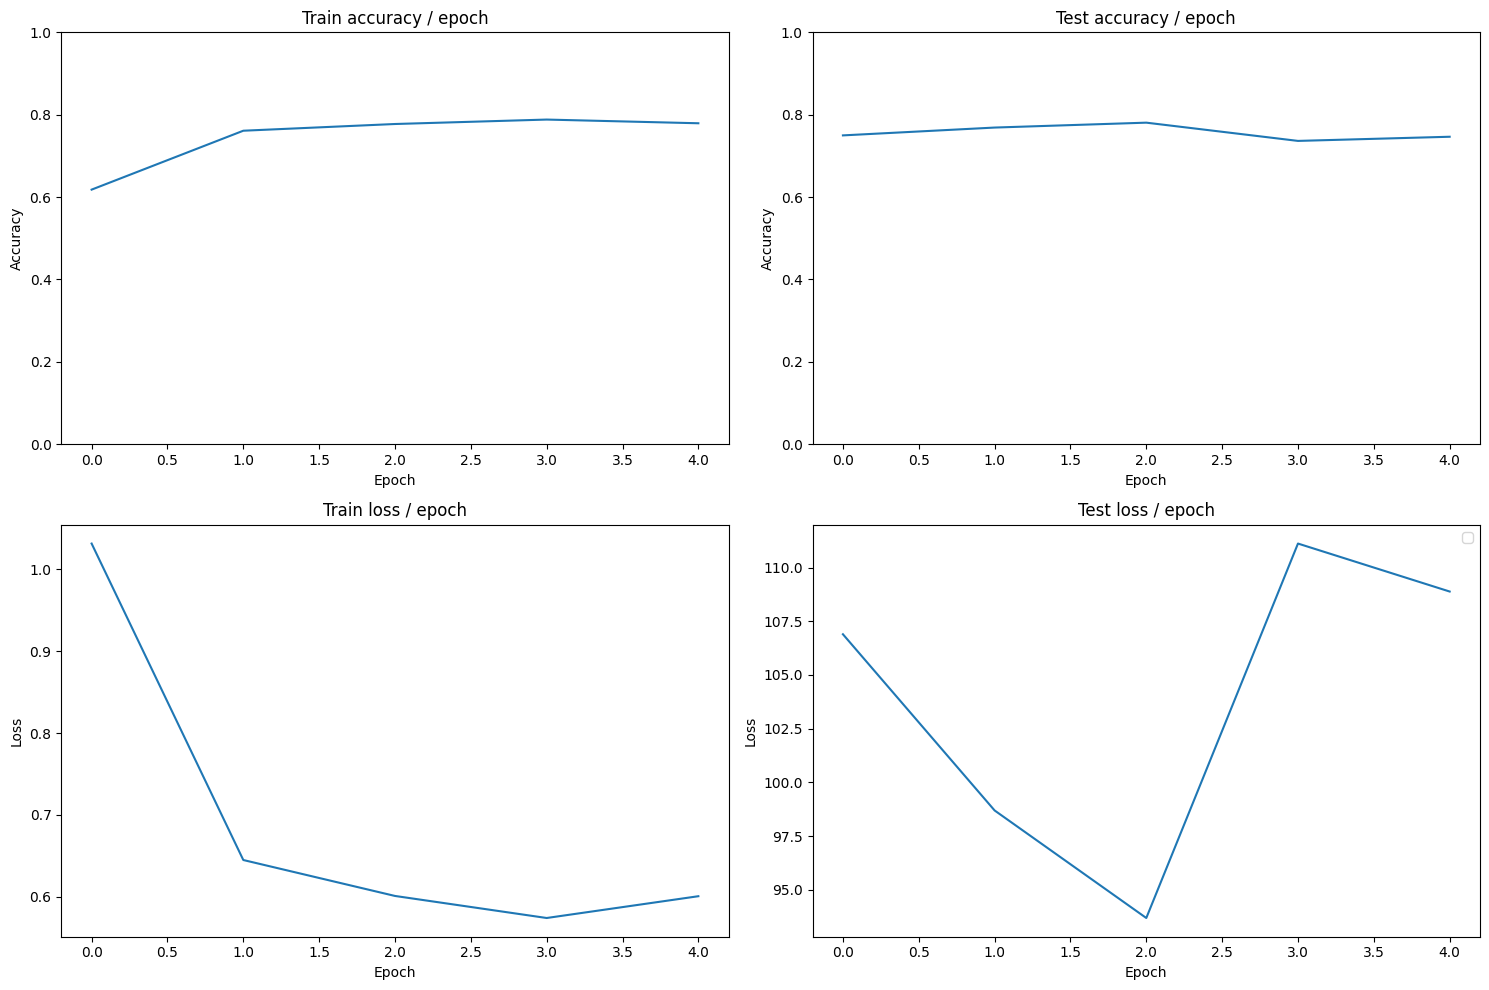

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

ax[0].plot(stats_pretrained[0])
ax[1].plot(stats_pretrained[1])
ax[2].plot(stats_pretrained[2])
ax[3].plot(stats_pretrained[3])

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 1])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 1])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("stats_vit_pretrained.pdf", dpi=100, bbox_inches="tight")
plt.show()

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.